# Twitch Insight: Data Collector & Collaboration Network Analyzer (v3 - Enhanced Prints)

This notebook automates the process of collecting data from the Twitch API, store it in a local SQLite database, and perform analysis, with a special focus on understanding collaboration networks between streamers. It identifies potential collaborations by detecting `@mentions` in video titles and descriptions, and also explores community structures within these networks. The primary interface for data collection, processing, and exploration is a Jupyter Notebook.

**Key Features:**
- Fetches top streams/categories periodically.
- Fetches channel details and video archives.
- Processes video titles/descriptions for `@mentions`.
- Looks up mentioned users via API if not in the database.
- Stores collaboration data (frequency, duration, recency).
- Processes mentions atomically per-video using DB transactions.
- Includes a refresh cycle for updating random channels.
- Provides data exploration for channels, videos, and the collaboration network.

**Modules Used:**
- `config.py`: Configuration (API keys, constants). Requires `.env` file.
- `database.py`: SQLite database interactions (schema, CRUD, upserts).
- `twitch_api.py`: Twitch Helix API communication (auth, rate limits).
- `network_utils.py`: Mention extraction and validation.

In [1]:
# %%
# Colab Environment Setup
import sys
if 'google.colab' in sys.modules:
    !git clone https://github.com/J-morag/TwitchSocialNetwork.git
    %cd TwitchSocialNetwork
    !pip install gdown
    !gdown --id 10UPIqV32_4tpwQL2HuzwErKh38RtLlhC
    print()
    %ls
    print()
    !pip install -r requirements.txt
    !pip uninstall -y community
    !pip install python-louvain

In [ ]:
# %%
# Colab Environment Setup for python-louvain

import sys
import subprocess
if 'google.colab' in sys.modules:
    print("--- Ensuring correct 'python-louvain' community detection library is installed ---")

    # Uninstall both potential conflicting packages to ensure a clean slate
    subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "community", "python-louvain"])

    # Install the correct package
    subprocess.check_call([sys.executable, "-m", "pip", "install", "python-louvain"])

    print("\nInstallation complete.")
    print("="*60)
    print("IMPORTANT: You MUST now restart the runtime for this change to take effect.")
    print("Go to the menu and select 'Runtime' -> 'Restart session' (or Ctrl+M .).")
    print("="*60)

In [2]:
# Cell 1: Imports and Setup
import logging
import time
import json
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, timezone
import re  # For parsing duration
import math  # For log scale checks
import random  # For refresh cycle
import networkx as nx  # For graph analysis
from ipywidgets import Text, Button, Dropdown, Output, VBox, Layout  # For interactive viz
from IPython.display import display, HTML  # For displaying widgets and potentially HTML

import sys
if 'google.colab' in sys.modules:
    import plotly.io as pio
    pio.renderers.default = "colab"

# Matplotlib will try this list of fonts in order until it finds one on your system.
# This list includes common fonts for Japanese, Chinese, and Korean on Windows/macOS.
plt.rcParams['font.family'] = ['Meiryo', 'Malgun Gothic', 'SimHei', 'Apple SD Gothic Neo', 'sans-serif']

pd.options.display.float_format = '{:,.0f}'.format

# --- Local Notebook Configuration ---
# Set to True for detailed progress and time estimations, False for minimal output.
VERBOSE_MODE = True
# Set to True to use channel profile pictures as nodes in graphs (slower).
# Set to False to use simple colored circles (faster).
USE_IMAGE_NODES = True

# Import custom modules
try:
    import config
    import database
    import twitch_api
    import network_utils
except ImportError as e:
    print(f"Error importing custom modules: {e}")
    print("Please ensure config.py, database.py, twitch_api.py, and network_utils.py are in the same directory.")
    raise SystemExit("Stopping notebook due to missing modules.")

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(module)s - %(message)s')

# --- Print Configuration ---
config.print_config()  # Call the function from config.py
print(f"\n[Notebook Settings]\n  VERBOSE_MODE: {VERBOSE_MODE}")

# --- Initialize ---
db_conn = None
api_client = None
try:
    print("\nInitializing database connection...")
    # Use settings from config.py
    db_conn = database.get_db_connection(config.DATABASE_NAME)
    database.initialize_database(db_conn)
    print(f"Database '{config.DATABASE_NAME}' initialized.")

    # Graceful API Client Initialization
    print("Initializing Twitch API client...")
    api_client = twitch_api.TwitchAPIClient(
        client_id=config.TWITCH_CLIENT_ID,
        client_secret=config.TWITCH_CLIENT_SECRET,
        auth_url=config.TWITCH_AUTH_URL,
        base_url=config.TWITCH_API_BASE_URL
    )
    if not api_client._authenticate():
         raise ConnectionError("Failed to authenticate with Twitch API.")
    print("API Client initialized and authenticated.")

except ValueError as e:
    # This will catch the credential error from the API client's __init__
    print("\n" + "="*50)
    print(f"WARNING: {e}")
    print("API Client could not be initialized. Data collection cells will be skipped.")
    print("Analysis of existing data in the database is still possible.")
    print("="*50)
except Exception as e:
    logging.critical(f"Initialization failed: {e}", exc_info=True)
    print(f"Initialization failed: {e}")
    if db_conn:
        db_conn.close()
    raise SystemExit("Stopping notebook due to initialization failure.")

print("-" * 30)
print(f"Setup Complete. Current time: {datetime.now().strftime('%Y-%M:%S')}")
print("-" * 30)

Configuration module 'config.py' loaded.


2025-08-29 17:17:14,430 - INFO - database - Database connection established to twitch_data.db
2025-08-29 17:17:14,431 - INFO - database - Initializing/verifying database schema...
2025-08-29 17:17:14,432 - INFO - database - Database schema initialized/verified successfully.


--- Configuration Settings ---

[API & Database]
  DATABASE_NAME: twitch_data.db

[Data Collection]
  NUM_TOP_CATEGORIES: 50
  NUM_STREAMS_PER_CATEGORY: 50
  REFETCH_CHANNEL_DETAILS_DAYS: 7
  REFETCH_CHANNEL_VIDEOS_DAYS: 2
  MENTION_PROC_BATCH_SIZE: 500
  MENTION_PROC_MAX_BATCHES: 100
  REFRESH_CYCLE_CHANNELS: 500
  FETCH_VIDEOS_AFTER: None

[Network Analysis Thresholds]
  NETWORK_MIN_COLLABORATION_COUNT: 2
  NETWORK_MIN_FOLLOWER_COUNT: 1000
  NETWORK_MIN_CHANNEL_VIDEO_COUNT: 5
  NETWORK_VIZ_TOP_N_CHANNELS_BY_DEGREE: 50
  NETWORK_VIZ_MAX_SUBGRAPH_NODES: 1000
----------------------------

[Notebook Settings]
  VERBOSE_MODE: True

Initializing database connection...
Database 'twitch_data.db' initialized.
Initializing Twitch API client...


2025-08-29 17:17:15,539 - INFO - twitch_api - Successfully obtained new access token. Expires around 2025-10-28 20:53:09 UTC.


API Client initialized and authenticated.
------------------------------
Setup Complete. Current time: 2025-17:15
------------------------------


In [3]:
# Cell 2: Helper Functions

def parse_duration_for_collab(duration_str):
    """
    Parses a Twitch duration string (e.g., "1h30m20s") into total seconds.
    """
    if not duration_str or not isinstance(duration_str, str):
        return 0 # Return 0 for invalid input

    total_seconds = 0
    hours = re.search(r'(\d+)h', duration_str)
    minutes = re.search(r'(\d+)m', duration_str)
    seconds = re.search(r'(\d+)s', duration_str)

    if hours:
        total_seconds += int(hours.group(1)) * 3600
    if minutes:
        total_seconds += int(minutes.group(1)) * 60
    if seconds:
        total_seconds += int(seconds.group(1))

    return total_seconds

def format_seconds_to_hm(seconds):
    """
    Formats a duration in seconds into a human-readable "Xh Ym" string.
    """
    if pd.isna(seconds) or seconds < 0:
        return "N/A"

    seconds = int(seconds)
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60

    return f"{hours}h {minutes:02}m"

print("Helper functions defined.")

Helper functions defined.


In [4]:
# %%
# Cell: Advanced Graph Drawing Helper Functions

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import requests
import os

# --- Image Caching and Drawing Logic ---

# Create a directory for caching images if it doesn't exist
IMAGE_CACHE_DIR = "image_cache"
if not os.path.exists(IMAGE_CACHE_DIR):
    os.makedirs(IMAGE_CACHE_DIR)

def get_cached_image(url, channel_id):
    """
    Downloads an image from a URL and caches it locally.
    Returns a Pillow Image object.
    """
    if not url or not isinstance(url, str): return None
    try:
        # Use a consistent filename based on channel ID
        filename = f"{channel_id}.png"
        filepath = os.path.join(IMAGE_CACHE_DIR, filename)

        if os.path.exists(filepath):
            # Load from cache
            return Image.open(filepath)
        else:
            # Download, save to cache, then return
            response = requests.get(url, stream=True, timeout=10)
            response.raise_for_status()
            img = Image.open(response.raw).convert("RGBA")
            img.save(filepath, 'PNG')
            return img
    except Exception as e:
        # logging.warning(f"Could not download or process image for channel {channel_id} from {url}: {e}")
        return None # Return None on any error

def draw_network_with_images(G, pos, node_data, community_partition, labels, ax):
    """
    Draws a networkx graph on a matplotlib axis, using channel profile pictures for nodes
    and correct text labels.
    """
    # Draw edges first, so they appear behind the nodes
    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray', ax=ax)

    # Prepare community colors
    unique_community_ids = sorted(list(set(community_partition.values())))
    community_to_color_idx = {cid: i for i, cid in enumerate(unique_community_ids)}
    cmap = plt.cm.get_cmap('tab20', len(unique_community_ids))

    # Draw each node as an image with a colored border
    for node_id in G.nodes():
        community_id = community_partition.get(node_id, -1)
        node_color = 'grey' if community_id == -1 else cmap(community_to_color_idx.get(community_id))

        node_info = node_data.loc[node_id] if node_id in node_data.index else None
        if node_info is None: continue

        follower_count = max(1, node_info.get('follower_count', 1))

        # Calculate size and zoom factors based on followers
        size_factor = math.log10(follower_count + 1)
        image_zoom = 0.02 * size_factor
        border_size = 0.025 * size_factor

        # 1. Draw the colored circle for the border
        ax.add_patch(plt.Circle(pos[node_id], radius=border_size, color=node_color, zorder=1))

        # 2. Get the cached profile picture
        img = get_cached_image(node_info.get('profile_image_url'), node_id)

        if img:
            # 3. Place the image on the graph
            imagebox = OffsetImage(img, zoom=image_zoom, resample=True)
            imagebox.image.axes = ax
            ab = AnnotationBbox(imagebox, pos[node_id], frameon=False, pad=0.0, zorder=2)
            ax.add_artist(ab)

    # Draw node labels using the provided `labels` dictionary
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, ax=ax,
                            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))


print("Advanced graph drawing helper function 'draw_network_with_images' is now defined.")

Advanced graph drawing helper function 'draw_network_with_images' is now defined.


## Data Collection Seeding

This section is responsible for seeding the database with channels and their videos by fetching top streams and channels. It can be run to initialize an empty database, or to discover new channels that are not a part of the social network of any known channel.


In [5]:
# Cell 2: Data Collection Cycle Function & Execution (Top Streams Focus)
def run_collection_cycle(current_api_client, current_db_conn):
    """
    Runs one cycle focused on fetching top streams, channels, and their videos.
    Mention processing is handled separately.
    """
    print(f"\n=== Starting Top Stream Data Collection Cycle at {datetime.now().strftime('%H:%M:%S')} ===")
    overall_start_time = time.time()

    # Phase 1: Fetch Top Categories
    phase_start_time = time.time()
    print("\n--- Phase 1: Fetching and Processing Top Categories ---")
    top_categories = current_api_client.get_top_games(config.NUM_TOP_CATEGORIES)
    if not top_categories: print("Could not fetch top categories. Cycle aborted."); return False
    database.save_categories(current_db_conn, top_categories)
    print(f"Phase 1: Processed {len(top_categories)} top categories in {time.time() - phase_start_time:.2f}s.")

    # Phase 2: Fetch Top Streams & Identify Channels
    phase_start_time = time.time()
    print("\n--- Phase 2: Fetching Top Streams & Identifying Channels from Categories ---")
    channels_to_process = set()
    categories_to_scan = database.get_categories_to_scan(current_db_conn, config.NUM_TOP_CATEGORIES)
    total_categories_to_scan = len(categories_to_scan)
    print(f"Found {total_categories_to_scan} categories prioritized for scanning.")
    category_processing_times = []

    for i, category_row in enumerate(categories_to_scan):
        cat_start_time = time.time()
        category_id = category_row['id']
        category_name = category_row['name']
        print(f" ({i + 1}/{total_categories_to_scan}) Processing category: {category_name}...")
        streams = current_api_client.get_streams_for_game(category_id, config.NUM_STREAMS_PER_CATEGORY)
        if streams:
            stream_channel_ids = set()
            for stream in streams:
                if 'user_id' in stream and 'user_login' in stream and 'user_name' in stream:
                    if database.save_channel_basic(current_db_conn, {
                        'id': stream['user_id'], 'login': stream['user_login'], 'display_name': stream['user_name']
                    }): stream_channel_ids.add(stream['user_id'])
            channels_to_process.update(stream_channel_ids)
        database.update_category_scan_time(current_db_conn, category_row['id'])

        cat_duration = time.time() - cat_start_time
        category_processing_times.append(cat_duration)
        if VERBOSE_MODE and category_processing_times and total_categories_to_scan > 0:
            avg_time_per_cat = sum(category_processing_times) / len(category_processing_times)
            est_remaining_cat_secs = (total_categories_to_scan - (i + 1)) * avg_time_per_cat
            if est_remaining_cat_secs > 0 and i < total_categories_to_scan - 1:
                est_cat_mins, est_cat_s = divmod(int(est_remaining_cat_secs), 60)
                print(f" -> Processed in {cat_duration:.2f}s. Est. remaining for categories: {est_cat_mins}m {est_cat_s}s")
            else:
                print(f" -> Processed in {cat_duration:.2f}s.")
        time.sleep(0.2)

    print(
        f"\nPhase 2: Identified {len(channels_to_process)} unique channels. Took {time.time() - phase_start_time:.2f}s.")

    # Phase 3: Fetch/Update Channel Details (MODIFIED for one-by-one fetching)
    phase_start_time = time.time()
    print("\n--- Phase 3: Fetching/Updating Channel Details (including Followers) ---")
    processed_channels_details = 0
    channels_needing_details_update = [
        chan_id for chan_id in list(channels_to_process)
        if database.check_channel_needs_update(current_db_conn, chan_id, config.REFETCH_CHANNEL_DETAILS_DAYS)
    ]
    total_to_update = len(channels_needing_details_update)
    print(f"{total_to_update} channels require detail fetching/updating.")
    detail_fetch_times = []

    if total_to_update > 0:
        for i, channel_id in enumerate(channels_needing_details_update):
            item_start_time = time.time()
            print(f" ({i + 1}/{total_to_update}) Fetching details for channel ID: {channel_id}...")

            # 1. Get user details (like login, description)
            user_details_list = current_api_client.get_user_details(user_ids=[channel_id])

            if user_details_list:
                user_data = user_details_list[0] # Get the first (and only) result

                # 2. Get follower count (separate API call)
                follower_count = current_api_client.get_channel_follower_count(broadcaster_id=channel_id)
                if follower_count is not None:
                    user_data['follower_count'] = follower_count

                # 3. Save combined data
                try:
                    database.save_channel_details(current_db_conn, user_data)
                    processed_channels_details += 1
                except Exception as e:
                    print(f" -> DB Error saving details for {user_data.get('login', channel_id)}: {e}")

            elif user_details_list is None:
                print(f" -> API call failed for details of channel {channel_id}. Skipping.")

            # Time estimation logic
            item_duration = time.time() - item_start_time
            detail_fetch_times.append(item_duration)
            if VERBOSE_MODE and detail_fetch_times:
                avg_time = sum(detail_fetch_times) / len(detail_fetch_times)
                est_rem_secs = (total_to_update - (i + 1)) * avg_time
                if est_rem_secs > 0:
                    est_mins, est_s = divmod(int(est_rem_secs), 60)
                    print(f" -> Processed in {item_duration:.2f}s. Est. remaining: {est_mins}m {est_s}s")

            time.sleep(0.3) # API courtesy between channels

    print(f"Phase 3: Finished. Attempted save for {processed_channels_details} channels. Took {time.time() - phase_start_time:.2f}s.")

    # Phase 4: Fetch/Update Channel Videos
    phase_start_time = time.time()
    print("\n--- Phase 4: Checking for and Fetching New Videos ---")
    channels_for_video_fetch = list(channels_to_process)
    total_channels_for_video = len(channels_for_video_fetch)
    print(f"Checking for new videos for {total_channels_for_video} channels from this cycle...")
    processed_channels_videos = 0; new_videos_found_total = 0
    video_fetch_times = []

    if total_channels_for_video > 0:
        for i, channel_id in enumerate(channels_for_video_fetch):
            ch_video_start_time = time.time()
            channel_info_for_log_cursor = current_db_conn.execute("SELECT login FROM Channels WHERE id = ?", (channel_id,))
            channel_info_for_log = channel_info_for_log_cursor.fetchone()
            channel_log_name = channel_info_for_log['login'] if channel_info_for_log else channel_id

            print(f" ({i + 1}/{total_channels_for_video}) Checking videos for channel: {channel_log_name}...")
            latest_stored_date = database.get_latest_video_date_for_channel(current_db_conn, channel_id)
            # This call fetches videos for channels just found in top streams
            new_videos = current_api_client.get_channel_videos(
                channel_id,
                video_type='archive',
                # Limit how many new videos to grab for a newly seen channel.
                # Helps prevent a single new channel from dominating the cycle time.
                limit=100,
                after_date=latest_stored_date
            )

            if new_videos:
                if VERBOSE_MODE: print(f" -> Found {len(new_videos)} new archive videos.")
                database.save_videos(current_db_conn, new_videos); new_videos_found_total += len(new_videos)
            elif new_videos is None:
                print(f" -> API call failed fetching videos for {channel_log_name}.")

            if new_videos is not None: database.update_channel_video_fetch_time(current_db_conn, channel_id)
            processed_channels_videos += 1

            ch_video_duration = time.time() - ch_video_start_time
            video_fetch_times.append(ch_video_duration)
            if VERBOSE_MODE and video_fetch_times:
                avg_time_per_ch_video = sum(video_fetch_times) / len(video_fetch_times)
                est_remaining_vid_secs = (total_channels_for_video - (i + 1)) * avg_time_per_ch_video
                if est_remaining_vid_secs > 0 and i < total_channels_for_video - 1:
                    est_vid_mins, est_vid_s = divmod(int(est_remaining_vid_secs), 60)
                    print(f" -> Processed in {ch_video_duration:.2f}s. Est. remaining for video checks: {est_vid_mins}m {est_vid_s}s")
                else:
                    print(f" -> Processed in {ch_video_duration:.2f}s.")
            time.sleep(0.5)

    print(f"\nPhase 4: Finished. Checked {processed_channels_videos} channels, found {new_videos_found_total} new videos. Took {time.time() - phase_start_time:.2f}s.")
    print(f"=== Top Stream Data Collection Cycle Finished in {time.time() - overall_start_time:.2f}s ===")
    return True

# # Run the collection cycle (you can comment this out after initial runs or run it selectively)
# if api_client:
#     print(f"\n--- Executing Data Collection Cycle (Top Streams) at {datetime.now().strftime('%H:%M:%S')} ---")
#     run_collection_cycle(api_client, db_conn)
#     print("-" * 30)
#     print("Data Collection Cycle (Top Streams) Done for this run.")
#     print("-" * 30)
# else:
#     print("\nAPI Client not available. Skipping Data Collection Cycle.")

## Mention Processing

This section processes videos to extract mentions (indicating collaborations) from their titles. New channels discovered through this process will be registered in the database, but we will not yet fetch these new channels' videos. Run this repeatedly until all videos in the database have been processed.


In [6]:
# Cell 3: Mention Processing Function (Atomic Per-Video)

# Helper function to parse duration
def parse_duration_for_collab(duration_str):
    """
    Parses a Twitch duration string (e.g., "1h30m20s") into total seconds.
    """
    if not duration_str or not isinstance(duration_str, str):
        return 0 # Return 0 for invalid input

    total_seconds = 0
    hours = re.search(r'(\d+)h', duration_str)
    minutes = re.search(r'(\d+)m', duration_str)
    seconds = re.search(r'(\d+)s', duration_str)

    if hours:
        total_seconds += int(hours.group(1)) * 3600
    if minutes:
        total_seconds += int(minutes.group(1)) * 60
    if seconds:
        total_seconds += int(seconds.group(1))

    return total_seconds


def process_video_mentions_batch(video_batch, current_api_client, current_db_conn):
    """
    Processes a batch of videos to find mentions, update collaborations.
    Discovers new channels via API for unknown mentions.
    Attempts atomic processing per video using DB transactions.
    """
    func_start_time = time.time()
    processed_count_in_batch = 0;
    newly_found_channels_in_batch = 0;
    updated_edges_in_batch = 0;
    all_unknown_logins_in_batch = set();
    temp_video_data = {}

    if VERBOSE_MODE: print(f"  Batch Start: {len(video_batch)} videos to process.")

    # Pass 1: Extract mentions and identify all unique unknown logins for the batch
    for video_row in video_batch:
         video_id = video_row['id']; title = video_row['title'] or ''; desc = video_row['description'] or ''
         text_to_scan = f"{title} {desc}"
         mentioned_logins = network_utils.extract_mentions(text_to_scan)
         temp_video_data[video_id] = {
             'owner_id': video_row['channel_id'], 'mentions': mentioned_logins,
             'published_at': video_row['published_at'], 'duration': video_row['duration']
         }
         if mentioned_logins:
             try:
                 _, not_found_now = network_utils.find_mentioned_channel_ids(mentioned_logins, current_db_conn);
                 all_unknown_logins_in_batch.update(not_found_now)
             except Exception as e:
                 logging.error(f"Error checking mentions in DB during Pass 1 for video {video_id}: {e}")

    # Pass 2: Fetch details for unknown mentioned logins via batched API calls
    newly_discovered_ids_this_pass = {}
    if all_unknown_logins_in_batch:
        unknown_logins_list = list(all_unknown_logins_in_batch)
        if VERBOSE_MODE: print(f"  Pass 2: Checking {len(unknown_logins_list)} unique unknown logins via API...")
        num_api_batches = (len(unknown_logins_list) + 99) // 100
        for i in range(num_api_batches):
            batch_logins = unknown_logins_list[i * 100:(i + 1) * 100]
            if VERBOSE_MODE: print(f"   -> API Batch {i + 1}/{num_api_batches} for {len(batch_logins)} logins...")
            time.sleep(0.2)
            user_details_list = current_api_client.get_user_details(user_logins=batch_logins);
            api_call_succeeded = user_details_list is not None
            if api_call_succeeded and user_details_list:
                for user_data in user_details_list:
                     try:
                         database.save_channel_details(current_db_conn, user_data);
                         login_lower = user_data['login'].lower();
                         user_id = user_data['id']
                         newly_discovered_ids_this_pass[login_lower] = user_id;
                         newly_found_channels_in_batch += 1
                     except Exception as e:
                         print(f"Error saving newly discovered channel {user_data.get('login')}: {e}")
            time.sleep(0.1)
        if VERBOSE_MODE: print(f"  Pass 2 Complete. Discovered and saved {newly_found_channels_in_batch} new channels.")

    # Pass 3: Process each video within its own database transaction
    for idx, (video_id, video_data) in enumerate(temp_video_data.items()):
        channel_id_A = video_data['owner_id'];
        mentioned_logins = video_data['mentions']
        published_at = video_data['published_at'];
        duration_str = video_data['duration']
        is_processed_successfully_this_video = False

        try:
            published_at_dt = published_at
            if not isinstance(published_at_dt, datetime):
                published_at_dt = pd.to_datetime(published_at, errors='coerce', utc=True)

            if pd.isna(published_at_dt):
                logging.warning(f"Invalid timestamp for video {video_id}. Skipping edges. Marking processed.")
                current_db_conn.execute('BEGIN')
                database.mark_video_mentions_processed(current_db_conn, video_id)
                current_db_conn.commit()
                processed_count_in_batch += 1
                is_processed_successfully_this_video = True

            elif not mentioned_logins:
                current_db_conn.execute('BEGIN')
                database.mark_video_mentions_processed(current_db_conn, video_id)
                current_db_conn.commit()
                processed_count_in_batch += 1
                is_processed_successfully_this_video = True
            else:
                current_known_ids, _ = network_utils.find_mentioned_channel_ids(mentioned_logins, current_db_conn)
                for login, user_id_new in newly_discovered_ids_this_pass.items():
                     if login in mentioned_logins:
                         current_known_ids[login] = user_id_new

                duration_sec = parse_duration_for_collab(duration_str)
                edges_for_this_video = 0
                mentions_to_add_list = []

                current_db_conn.execute('BEGIN IMMEDIATE')
                for login, channel_id_B in current_known_ids.items():
                    if channel_id_A != channel_id_B:
                        database.upsert_collaboration_edge(current_db_conn, channel_id_A, channel_id_B, published_at_dt, duration_sec)
                        mentions_to_add_list.append((channel_id_A, channel_id_B, video_id, published_at_dt))
                        edges_for_this_video += 1

                if mentions_to_add_list:
                    database.add_mentions(current_db_conn, mentions_to_add_list)

                database.mark_video_mentions_processed(current_db_conn, video_id)
                current_db_conn.commit()

                processed_count_in_batch += 1
                updated_edges_in_batch += edges_for_this_video
                is_processed_successfully_this_video = True

        except Exception as e:
            if not is_processed_successfully_this_video:
                 try:
                     current_db_conn.rollback()
                 except sqlite3.Error as rb_err:
                     logging.error(f"Error during rollback for video {video_id}: {rb_err}")
                 logging.error(f"Error processing video {video_id} within transaction", exc_info=True)

    return processed_count_in_batch, newly_found_channels_in_batch, updated_edges_in_batch

## Refresh Cycle

This section periodically updates details and recent videos for a prioritized subset of channels in the database. It focuses on channels that have not been updated recently ("stalest" channels), ensuring the dataset remains current without re-fetching all channels every cycle. The refresh cycle:

* Selects a configurable number of the stalest channels based on last update timestamps.
* Updates each channel's details (including follower count).
* Fetches and stores new videos for each refreshed channel.
* Helps maintain up-to-date collaboration and content data for ongoing analysis.

Run this cycle regularly to keep your database fresh and to discover new videos as channels continue to stream and as we discover new channels. Run it repeatedly until refreshes do not produce significant updates, at which point you can go back to the Mention Processing section to process the new videos.

In [8]:
# %%
# Cell 5: Refresh Function (Highly Optimized with Batching and Error Handling)

def run_refresh_cycle(current_api_client, current_db_conn, num_channels_to_refresh):
    """
    Refreshes details and fetches recent videos for a prioritized subset of
    the "stalest" channels. Uses batching for all possible API calls to maximize efficiency
    and correctly handles channels that fail the API lookup.
    """
    print(f"\n--- Starting Prioritized Channel Refresh Cycle at {datetime.now().strftime('%H:%M:%S')} ---")
    overall_refresh_start_time = time.time()
    processed_count = 0; new_videos_found_total = 0
    channel_refresh_times = []

    try:
        # 1. Get a prioritized list of channels to refresh
        print(f"Fetching up to {num_channels_to_refresh} of the stalest channels from the database...")
        channels_to_refresh_rows = database.get_stale_channels_for_refresh(current_db_conn, num_channels_to_refresh)
        actual_to_refresh_count = len(channels_to_refresh_rows)

        if not channels_to_refresh_rows:
            print("No channels found to refresh.")
            return 0, 0

        channel_ids_to_refresh = [row['id'] for row in channels_to_refresh_rows]
        print(f"Prioritized list created. Preparing to refresh {actual_to_refresh_count} channels...")

        # --- 2. Batch fetch all possible data first ---
        print("\nBatch fetching user details and channel info (tags)...")
        user_details_map = {}
        tags_map = {}

        for i in range(0, len(channel_ids_to_refresh), 100):
            batch_ids = channel_ids_to_refresh[i:i+100]
            if VERBOSE_MODE: print(f" -> Fetching batch {i//100 + 1} ({len(batch_ids)} channels)...")

            # Batch call for user details (description, etc.)
            user_details_batch = current_api_client.get_user_details(user_ids=batch_ids)
            if user_details_batch:
                for user in user_details_batch:
                    user_details_map[user['id']] = user

            # Batch call for channel info (tags, etc.)
            channels_info_batch = current_api_client.get_channels_info(broadcaster_ids=batch_ids)
            if channels_info_batch:
                for channel in channels_info_batch:
                    tags_map[channel['broadcaster_id']] = channel.get('tags', [])

            time.sleep(0.2)

        print(f" -> Received details for {len(user_details_map)} channels and tags for {len(tags_map)} channels.")

        # --- 3. Iterate through each channel for the remaining individual API calls ---
        for i, channel_id in enumerate(channel_ids_to_refresh):
            channel_refresh_start_time = time.time()

            user_data = user_details_map.get(channel_id)

            if not user_data:
                print(f"\n ({i + 1}/{actual_to_refresh_count}) Details for channel {channel_id} not found in batch fetch (channel may be banned/deleted).")
                print(" -> Marking as processed to avoid re-checking in the near future.")

                # Mark both timestamps as updated so it's moved to the back of the queue
                database.update_channel_video_fetch_time(current_db_conn, channel_id)
                database.update_channel_detail_fetch_time(current_db_conn, channel_id)
                processed_count += 1
                continue # Skip to the next channel in the list

            channel_log_name = user_data.get('login', channel_id)
            print(f"\n ({i + 1}/{actual_to_refresh_count}) Processing channel: {channel_log_name}...")

            # Add pre-fetched tags to the user data object
            user_data['tags'] = tags_map.get(channel_id)

            # API Call 1: Get follower count (must be individual)
            follower_count = current_api_client.get_channel_follower_count(broadcaster_id=channel_id)
            if follower_count is not None:
                user_data['follower_count'] = follower_count

            # Save the combined details (details, tags, followers)
            try:
                database.save_channel_details(current_db_conn, user_data)
            except Exception as e:
                print(f"  -> DB Error saving details for channel {channel_id}: {e}")

            # API Call 2: Fetch new videos (must be individual)
            latest_stored_date = database.get_latest_video_date_for_channel(current_db_conn, channel_id)
            new_videos = current_api_client.get_channel_videos(channel_id, video_type='archive', limit=50, after_date=latest_stored_date)

            if new_videos:
                if VERBOSE_MODE: print(f" -> Found {len(new_videos)} new archive videos.")
                database.save_videos(current_db_conn, new_videos)
                new_videos_found_total += len(new_videos)

            if new_videos is not None:
                database.update_channel_video_fetch_time(current_db_conn, channel_id)

            processed_count += 1

            # Time estimation logic
            channel_refresh_duration = time.time() - channel_refresh_start_time
            channel_refresh_times.append(channel_refresh_duration)
            if VERBOSE_MODE and channel_refresh_times:
                avg_time_per_refresh = sum(channel_refresh_times) / len(channel_refresh_times)
                remaining_refreshes = actual_to_refresh_count - (i + 1)
                est_remaining_refresh_secs = remaining_refreshes * avg_time_per_refresh
                if est_remaining_refresh_secs > 0 and i < actual_to_refresh_count - 1:
                    est_ref_mins, est_ref_s = divmod(int(est_remaining_refresh_secs), 60)
                    print(f" -> Refreshed in {channel_refresh_duration:.2f}s. Est. time remaining: {est_ref_mins}m {est_ref_s}s")

            time.sleep(0.5)

        print(f"\n--- Channel Refresh Cycle Finished in {time.time() - overall_refresh_start_time:.2f}s ---")
        print(f"Attempted refresh for {processed_count} channels.")
        print(f"Found {new_videos_found_total} new videos in total during refresh.")

        return new_videos_found_total, processed_count

    except Exception as e:
        print(f"An error occurred during refresh cycle: {e}")
        logging.error("Error in refresh cycle", exc_info=True)
        return 0, 0

# Automated Data Collection Main Loop

The following cell defines and runs the main automation function, `run_automated_main_loop`. This function is designed to intelligently run the different data collection cycles until the database is considered "up-to-date" and stable. It serves as a "run and walk away" alternative to manually running each cycle.

The loop operates in a sequence of "meta-cycles," each following a specific priority order:

1.  **Phase 1: Process All Mentions**
    * The loop's first priority is to process the `mentions` for all videos currently in the database that haven't been checked yet.
    * It will run the mention processing cycle repeatedly until the queue of unprocessed videos is empty. This ensures that all existing data is fully integrated into the collaboration network before new data is fetched.

2.  **Phase 2: Refresh Until Stable**
    * Once the mention queue is clear, the loop begins running the `run_refresh_cycle` to update stale channels and fetch their newest videos.
    * It continues to run this refresh cycle as long as the updates are considered "significant." A significant update is defined by finding a number of new videos that is greater than a certain percentage of the channels refreshed in that cycle (e.g., more than 10%, controlled by `REFRESH_SIGNIFICANCE_THRESHOLD`).
    * When a refresh cycle produces very few new videos, the database is considered stable, and this phase concludes.

3.  **Phase 3: Final Collection & Loop Decision**
    * **If the Refresh Phase was busy** (meaning it ran more than once and added a lot of new videos), the main loop will restart from Phase 1. This is crucial because the new videos need to have their mentions processed.
    * **If the Refresh Phase was quiet** (meaning it ran only once or not at all), the script assumes the database is stable. It performs one final `run_collection_cycle` to seed the database with the latest top streams and then gracefully stops the automation.

This entire process is wrapped with safety limits (`MAX_META_CYCLES`, etc.) to prevent any potential for infinite loops.

Running this may take a very long time.

In [10]:
# %%
# Cell: Automated Data Collection Main Loop

def run_automated_main_loop(api_client, db_conn):
    """
    Runs the data collection cycles iteratively until the database is in a
    stable, up-to-date state.
    """
    print("="*60)
    print(f"AUTOMATED DATA COLLECTION LOOP STARTED at {datetime.now().strftime('%H:%M:%S')}")
    print("="*60)

    # --- Automation Parameters ---
    REFRESH_SIGNIFICANCE_THRESHOLD = 4
    MAX_META_CYCLES = 10
    MAX_MENTION_LOOPS_PER_CYCLE = 200
    MAX_REFRESH_LOOPS_PER_CYCLE = 20

    meta_cycles_run = 0
    while meta_cycles_run < MAX_META_CYCLES:
        meta_cycles_run += 1
        print(f"\n--- Starting Meta-Cycle {meta_cycles_run}/{MAX_META_CYCLES} ---")

        # --- PHASE 1: Process all existing mentions until queue is empty ---
        print("\n>>> Phase 1: Processing mentions for unprocessed videos...")
        mention_loops_run = 0
        total_mentions_processed_this_phase = 0
        total_new_channels_this_phase = 0
        total_edges_upserted_this_phase = 0

        while mention_loops_run < MAX_MENTION_LOOPS_PER_CYCLE:
            mention_loops_run += 1
            unprocessed_count = db_conn.execute("SELECT COUNT(*) FROM Videos WHERE mentions_processed_at IS NULL").fetchone()[0]

            if unprocessed_count == 0:
                print("All mentions processed. Moving to next phase.")
                break

            print(f"\nRunning mention processing batch {mention_loops_run} (Unprocessed videos remaining: {unprocessed_count})...")
            videos_to_process = database.get_unprocessed_videos_batch(db_conn, config.MENTION_PROC_BATCH_SIZE)

            if not videos_to_process:
                print("Warning: Unprocessed count was > 0 but no videos were fetched. Breaking mention loop.")
                break

            batch_start_time = time.time()

            # --- Capture return values and print summary ---
            count, new_chans, edges = process_video_mentions_batch(videos_to_process, api_client, db_conn)
            batch_duration = time.time() - batch_start_time

            print(f" -> Batch complete in {batch_duration:.2f}s. Processed: {count} videos, Found: {new_chans} new channels, Upserted: {edges} edges.")

            # Update phase totals
            total_mentions_processed_this_phase += count
            total_new_channels_this_phase += new_chans
            total_edges_upserted_this_phase += edges

        else: # This 'else' belongs to the 'while' loop
            print("Warning: Mention processing reached max loops. Moving on to prevent infinite loop.")

        print(f"\n--- Mention Processing Phase Summary ---")
        # Adjust run count if loop broke on first check
        final_mention_loops_run = mention_loops_run - 1 if unprocessed_count == 0 else mention_loops_run
        print(f"Ran {final_mention_loops_run} batch(es).")
        print(f"Total Videos Processed: {total_mentions_processed_this_phase}")
        print(f"Total New Channels Found: {total_new_channels_this_phase}")
        print(f"Total Edges Upserted: {total_edges_upserted_this_phase}")


        # --- PHASE 2: Refresh stale channels until no significant updates are found ---
        print("\n>>> Phase 2: Refreshing stale channels until database stabilizes...")
        refresh_cycles_run = 0
        while refresh_cycles_run < MAX_REFRESH_LOOPS_PER_CYCLE:
            refresh_cycles_run += 1
            print(f"\nRunning refresh cycle {refresh_cycles_run}...")

            new_videos, channels_refreshed = run_refresh_cycle(
                api_client, db_conn, config.REFRESH_CYCLE_CHANNELS
            )

            if channels_refreshed == 0:
                print("Refresh cycle found no channels to process. Database is stable.")
                break

            significance_limit = channels_refreshed * REFRESH_SIGNIFICANCE_THRESHOLD
            if new_videos < significance_limit:
                print(f"Refresh cycle found only {new_videos} new videos, which is below the significance threshold of {significance_limit:.1f}. Concluding refresh phase.")
                break
            else:
                print(f"Found {new_videos} new videos. Updates were significant, another refresh cycle may be needed.")
        else:
            print("Warning: Refresh phase reached max loops. Moving on to prevent infinite loop.")


        # --- PHASE 3: Decide whether to loop back or finish ---
        print("\n>>> Phase 3: Evaluating next step...")
        if refresh_cycles_run > 1:
            print("Significant updates were made during refresh. Looping back to process mentions from newly added videos.")
            continue
        else:
            print("Database is stable. Running one final top-stream collection cycle...")
            run_collection_cycle(api_client, db_conn)

            print("\nAutomation complete. The database is now in a stable, up-to-date state.")
            break

    else:
        print(f"\nAutomation stopped after reaching maximum meta-cycles ({MAX_META_CYCLES}). This is a safeguard against infinite loops.")

    print("="*60)
    print(f"AUTOMATED DATA COLLECTION LOOP FINISHED at {datetime.now().strftime('%H:%M:%S')}")
    print("="*60)


# --- Execute the Automated Loop ---
# You can run this cell to start the full automated process (may take many hours)
if api_client:
    # Execute the Automated Loop
    run_automated_main_loop(api_client, db_conn)
else:
    print("\nAPI Client not available. Skipping Automated Data Collection Loop.")

# Data Exploration

Load the collected data from the database into pandas DataFrames and perform basic analysis and visualization.


In [11]:
# %%
# Cell 7: Load Data from Database
print(f"\n--- Loading Data for Exploration at {datetime.now().strftime('%H:%M:%S')} ---")
try:
    channel_date_cols = ['created_at', 'first_seen', 'last_fetched_details', 'last_fetched_videos']
    video_date_cols = ['published_at', 'created_at_api', 'fetched_at', 'mentions_processed_at']
    category_date_cols = ['last_scanned_top_streams']

    print("Loading Channels table...")
    channels_df = pd.read_sql_query("SELECT * FROM Channels", db_conn)
    print("Loading Videos table...")
    videos_df = pd.read_sql_query("SELECT * FROM Videos", db_conn)
    print("Loading Categories table...")
    categories_df = pd.read_sql_query("SELECT * FROM Categories", db_conn)

    # --- NEW: Load the Mentions table ---
    print("Loading Mentions table...")
    mentions_df = pd.read_sql_query("SELECT * FROM Mentions", db_conn)

    # Convert timestamp columns
    print("Converting timestamp columns...")
    for col in channel_date_cols:
        if col in channels_df.columns: channels_df[col] = pd.to_datetime(channels_df[col], errors='coerce', utc=True)
    for col in video_date_cols:
        if col in videos_df.columns: videos_df[col] = pd.to_datetime(videos_df[col], errors='coerce', utc=True)
    for col in category_date_cols:
         if col in categories_df.columns: categories_df[col] = pd.to_datetime(categories_df[col], errors='coerce', utc=True)
    # Convert timestamp in the new mentions_df
    if 'mention_timestamp' in mentions_df.columns:
        mentions_df['mention_timestamp'] = pd.to_datetime(mentions_df['mention_timestamp'], errors='coerce', utc=True)


    # Convert numeric columns, coercing errors
    print("Converting numeric columns and parsing durations...")
    channels_df['follower_count'] = pd.to_numeric(channels_df['follower_count'], errors='coerce')
    channels_df['display_name'] = channels_df['display_name'].fillna(channels_df['login'])
    videos_df['duration_seconds'] = videos_df['duration'].apply(parse_duration_for_collab).fillna(0).astype(int)

    print(f"Loaded {len(channels_df)} channels, {len(videos_df)} videos, {len(categories_df)} categories, and {len(mentions_df)} mentions.")
    print("--- Data Loading Complete ---")


except Exception as e:
    print(f"Error loading data from database: {e}")
    raise SystemExit("Stopping notebook due to data loading failure.")


--- Loading Data for Exploration at 17:17:16 ---
Loading Channels table...
Loading Videos table...
Loading Categories table...
Loading Mentions table...
Converting timestamp columns...
Converting numeric columns and parsing durations...
Loaded 161945 channels, 4159939 videos, 283 categories, and 665040 mentions.
--- Data Loading Complete ---


In [12]:
# Cell 8: Display Sample Data
print("\nSample Channels Data:")
display(channels_df.head())
print("\nSample Videos Data:")
display(
    videos_df[['id', 'channel_id', 'title', 'published_at', 'view_count', 'duration_seconds', 'mentions_processed_at',
               'game_name']].head())
print("\nSample Categories Data:")
display(categories_df.head())



Sample Channels Data:


id           login  display_name  \
0   67708794             nix           Nix   
1  403594122          zarbex        zarbex   
2  107117952    jasontheween  jasontheween   
3  132501030      clemovitch    Clemovitch   
4  952340772  hiiragitsurugi          柊ツルギ   

                                         description  \
0  Фрукты не дышать корень имбиря стоять на голов...   
1                                    GEIL GEMACHT 🗣️   
2      Hi Im Jason ; contact: Jason@unitedtalent.com   
3  Clément Viktorovitch : docteur, auteur, stream...   
4                 毎日面白い配信を心がけています！！配信の切り抜きはYoutubeにて   

                                   profile_image_url broadcaster_type  \
0  https://static-cdn.jtvnw.net/jtv_user_pictures...          partner   
1  https://static-cdn.jtvnw.net/jtv_user_pictures...          partner   
2  https://static-cdn.jtvnw.net/jtv_user_pictures...          partner   
3  https://static-cdn.jtvnw.net/jtv_user_pictures...          partner   
4  https://static-cdn.jtvnw.net/jtv_user_pictures...          partner   

   view_count                created_at                first_seen  \
0           0 2014-07-30 12:03:35+00:00 2025-06-16 12:43:02+00:00   
1           0 2018-12-22 15:32:01+00:00 2025-06-16 12:43:02+00:00   
2           0 2015-11-14 21:17:02+00:00 2025-06-16 12:43:03+00:00   
3           0 2016-08-18 08:47:25+00:00 2025-06-16 12:43:03+00:00   
4           0 2023-09-04 12:47:08+00:00 2025-06-16 12:43:03+00:00   

              last_fetched_details              last_fetched_videos  \
0 2025-08-26 18:49:41.871100+00:00 2025-08-26 18:49:42.119097+00:00   
1 2025-08-26 07:36:18.791325+00:00 2025-08-26 07:36:19.029642+00:00   
2 2025-08-28 03:08:10.575204+00:00 2025-08-28 03:08:10.812379+00:00   
3 2025-08-25 12:12:41.327420+00:00 2025-08-25 12:12:41.554421+00:00   
4 2025-08-27 14:16:50.872729+00:00 2025-08-27 14:16:51.141188+00:00   

   follower_count                                               tags  
0         962,663     ["\u0420\u0443\u0441\u0441\u043a\u0438\u0439"]  
1       1,069,106                 ["Deutsch", "geil", "g\u00f6nrgy"]  
2       1,692,549                                        ["English"]  
3         177,824                                  ["Fran\u00e7ais"]  
4         378,706  ["\u65e5\u672c\u8a9e", "\u96d1\u8ac7", "\u30b2...


Sample Videos Data:


id channel_id                                              title  \
0  2487349414   26341777  rogue master / the return of the brick / !stee...   
1  2486509959   26341777  rogue master / the return of the brick / !stee...   
2  2485587564   26341777  Classic Anniversary / Rank 14 Rogue / !steelse...   
3  2484694716   26341777  PSHERO CLASSIC ROGUE / educational stream / EU...   
4  2483818273   26341777  PSHERO CLASSIC ROGUE / educational stream / MO...   

               published_at  view_count  duration_seconds  \
0 2025-06-16 05:09:54+00:00          14             27200   
1 2025-06-15 05:58:45+00:00       25355             33300   
2 2025-06-14 05:23:11+00:00       22159             34010   
3 2025-06-13 06:01:13+00:00       18718             32780   
4 2025-06-12 05:54:58+00:00       14424             26050   

             mentions_processed_at game_name  
0 2025-06-17 16:19:10.549762+00:00      None  
1 2025-06-17 16:19:10.559310+00:00      None  
2 2025-06-17 16:19:10.567058+00:00      None  
3 2025-06-17 16:19:10.575090+00:00      None  
4 2025-06-17 16:19:10.582913+00:00      None


Sample Categories Data:


id                name         last_scanned_top_streams
0  509658       Just Chatting 2025-08-29 05:02:13.089657+00:00
1   21779   League of Legends 2025-08-29 05:02:22.850887+00:00
2   29595              Dota 2 2025-08-29 05:02:23.864125+00:00
3  516575            VALORANT 2025-08-29 05:02:28.888157+00:00
4   32982  Grand Theft Auto V 2025-08-29 05:02:31.694493+00:00

In [13]:
# Cell 9: Basic Statistics
print("\n--- Basic Statistics ---")
print("\nChannel Statistics:")
print(f"Total Channels: {len(channels_df)}")
print("\nBroadcaster Types:")
print(channels_df['broadcaster_type'].value_counts(dropna=False))
print("\nChannel Follower Count Summary:")
print(channels_df['follower_count'].describe())
print(f"Channels missing details: {channels_df['last_fetched_details'].isnull().sum()}")

print("\nVideo Statistics:")
print(f"Total Videos: {len(videos_df)}")
print("\nVideo Types:")
print(videos_df['type'].value_counts(dropna=False))
print("\nVideo View Count Summary:")
print(videos_df['view_count'].describe())
print("\nVideo Duration (seconds) Summary:")
print(videos_df['duration_seconds'].describe())
print(f"Videos with mentions processed: {videos_df['mentions_processed_at'].notnull().sum()}")
print(f"Videos pending mention processing: {videos_df['mentions_processed_at'].isnull().sum()}")


--- Basic Statistics ---

Channel Statistics:
Total Channels: 161945

Broadcaster Types:
broadcaster_type
affiliate    108393
              34826
partner       18662
None             64
Name: count, dtype: int64

Channel Follower Count Summary:
count      161,872
mean        15,267
std        168,294
min              0
25%            120
50%            433
75%          1,777
max     19,234,071
Name: follower_count, dtype: float64
Channels missing details: 3

Video Statistics:
Total Videos: 4159939

Video Types:
type
archive    4159939
Name: count, dtype: int64

Video View Count Summary:
count    4,159,939
mean         4,324
std         48,674
min              0
25%             37
50%            146
75%            800
max     22,404,842
Name: view_count, dtype: float64

Video Duration (seconds) Summary:
count   4,159,939
mean       16,195
std        33,665
min             0
25%         8,340
50%        13,417
75%        19,886
max     4,344,146
Name: duration_seconds, dtype: float64
Vi

## Data Visualization (Channels & Videos)



--- Channel Visualizations ---
Generating Channel Follower Count Histogram...


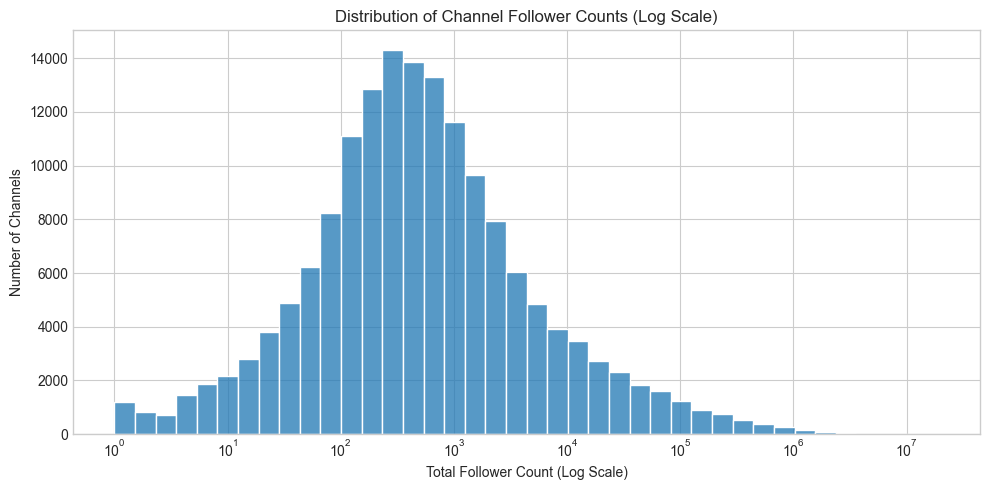

Generating Broadcaster Types Bar Chart...


C:\Users\User\AppData\Local\Temp\ipykernel_24592\3486324739.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=channel_types, order=channel_types.value_counts().index, palette='viridis');


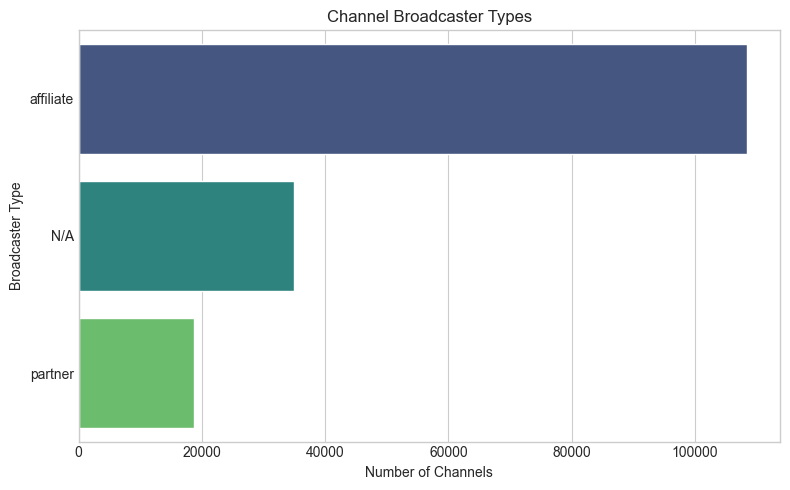

In [14]:
# Cell 10: Visualizations - Channels
print("\n--- Channel Visualizations ---")
plt.style.use('seaborn-v0_8-whitegrid')

# --- UPDATED: Histogram of Channel Follower Counts ---
print("Generating Channel Follower Count Histogram...")
plt.figure(figsize=(10, 5));
# Use the 'follower_count' column now, and drop any rows where it might be NaN
followers_positive = channels_df.dropna(subset=['follower_count'])
followers_positive = followers_positive[followers_positive['follower_count'] > 0]['follower_count']

if not followers_positive.empty:
    # Determine if log scale is needed by checking the data range
    should_use_log = (followers_positive.max() / followers_positive.min() > 100) if followers_positive.min() > 0 else False

    # Conditionally set the plotting arguments
    plot_kwargs = {'bins': 40, 'kde': False}
    if should_use_log:
        plot_kwargs['log_scale'] = True # Set to True, not a variable that could be False
        title = 'Distribution of Channel Follower Counts (Log Scale)'
        xlabel = 'Total Follower Count (Log Scale)'
    else:
        # Do not pass log_scale when it's not needed
        title = 'Distribution of Channel Follower Counts'
        xlabel = 'Total Follower Count'

    sns.histplot(followers_positive, **plot_kwargs)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Number of Channels')
    plt.tight_layout()
    plt.show()
else:
    print("No positive channel follower data to plot histogram yet.")

print("Generating Broadcaster Types Bar Chart...")
plt.figure(figsize=(8, 5));
channel_types = channels_df['broadcaster_type'].fillna('N/A').replace('', 'N/A')
sns.countplot(y=channel_types, order=channel_types.value_counts().index, palette='viridis');
plt.title('Channel Broadcaster Types')
plt.xlabel('Number of Channels')
plt.ylabel('Broadcaster Type')
plt.tight_layout()
plt.show()


--- Video Visualizations ---
Generating Video View Count Histogram...


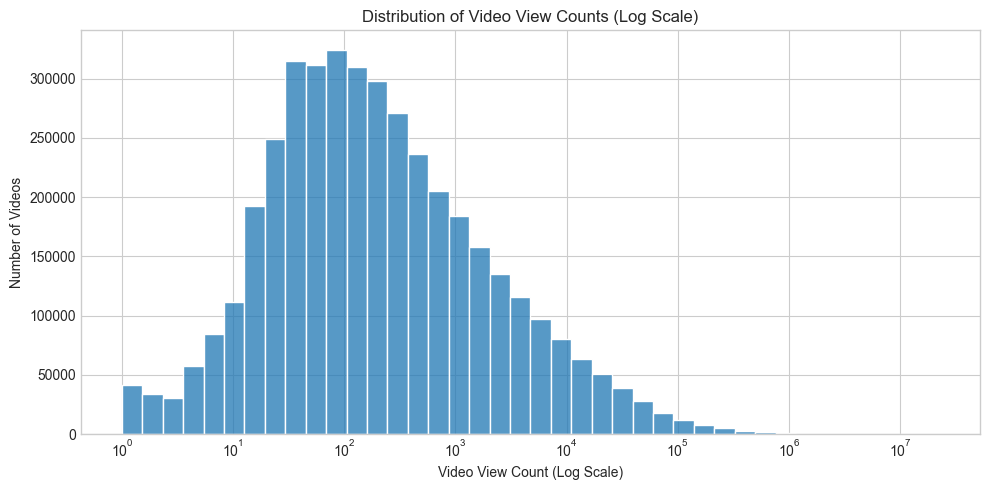

Generating Video Types Bar Chart...


C:\Users\User\AppData\Local\Temp\ipykernel_24592\2500711648.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=video_types, order=video_types.value_counts().index, palette='magma');


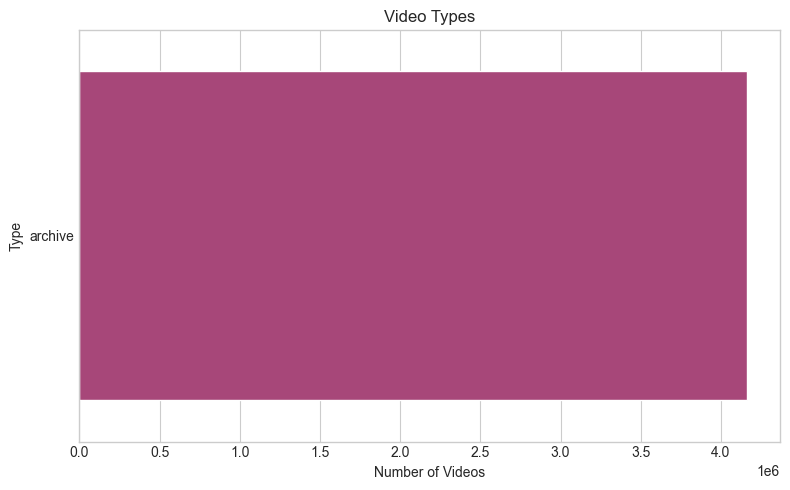

Generating Video Publication Time Series...
Displaying time series from 2025-05-05 onwards (showing 95% of the data).


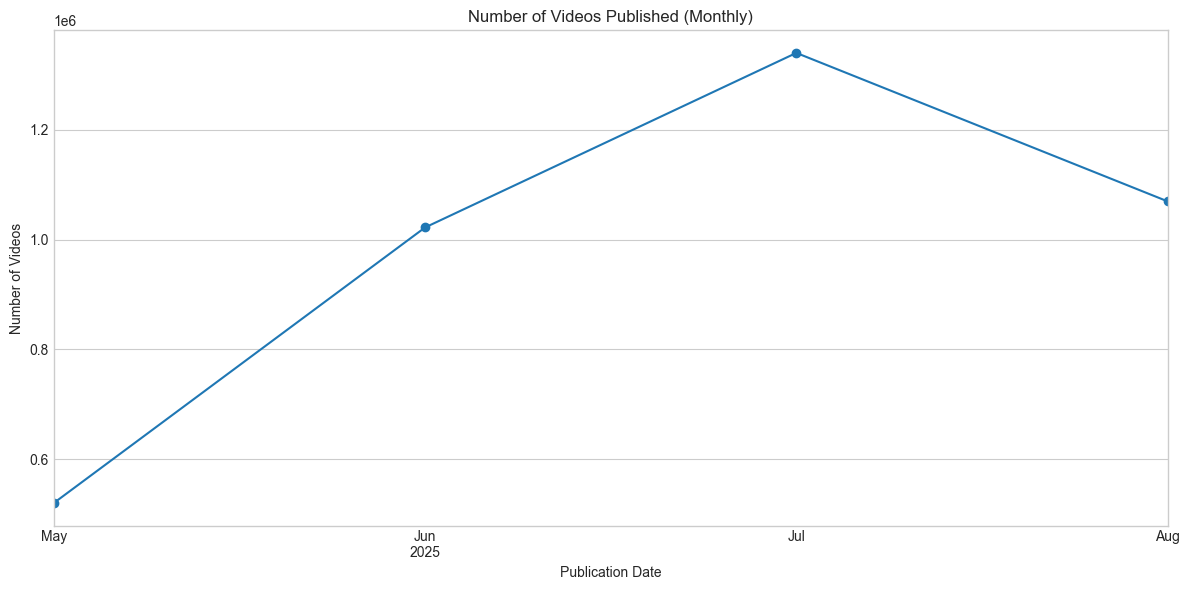

In [15]:
# Cell 11: Visualizations - Videos
print("\n--- Video Visualizations ---")

print("Generating Video View Count Histogram...")
plt.figure(figsize=(10, 5));
views_positive_vid = videos_df.dropna(subset=['view_count'])
views_positive_vid = views_positive_vid[views_positive_vid['view_count'] > 0]['view_count']

if not views_positive_vid.empty:
    # Determine if log scale is needed
    should_use_log_vid = (views_positive_vid.max() / views_positive_vid.min() > 100) if views_positive_vid.min() > 0 else False

    # Conditionally set the plotting arguments
    plot_kwargs_vid = {'bins': 40, 'kde': False}
    if should_use_log_vid:
        plot_kwargs_vid['log_scale'] = True
        title_vid = 'Distribution of Video View Counts (Log Scale)'
        xlabel_vid = 'Video View Count (Log Scale)'
    else:
        title_vid = 'Distribution of Video View Counts'
        xlabel_vid = 'Video View Count'

    sns.histplot(views_positive_vid, **plot_kwargs_vid)
    plt.title(title_vid)
    plt.xlabel(xlabel_vid)
    plt.ylabel('Number of Videos')
    plt.tight_layout()
    plt.show()
else:
    print("No positive video view data to plot histogram.")

print("Generating Video Types Bar Chart...")
plt.figure(figsize=(8, 5));
video_types = videos_df['type'].fillna('N/A');
sns.countplot(y=video_types, order=video_types.value_counts().index, palette='magma');
plt.title('Video Types');
plt.xlabel('Number of Videos');
plt.ylabel('Type');
plt.tight_layout();
plt.show()

# --- Video Publication Time Series ---
print("Generating Video Publication Time Series...")
plt.figure(figsize=(12, 6));
video_pub_dates = videos_df.dropna(subset=['published_at'])

if not video_pub_dates.empty and len(video_pub_dates) > 1:
    # --- Calculate the 5th percentile date to set the start range ---
    start_date = video_pub_dates['published_at'].quantile(0.05)
    print(f"Displaying time series from {start_date.strftime('%Y-%m-%d')} onwards (showing 95% of the data).")

    # Filter the DataFrame to this new date range
    plotting_df = video_pub_dates[video_pub_dates['published_at'] >= start_date]

    # --- Use the filtered plotting_df for the rest of the logic ---
    if not plotting_df.empty:
        time_range_days = (plotting_df['published_at'].max() - plotting_df['published_at'].min()).days if len(plotting_df) > 1 else 0
        resample_freq = 'ME' if time_range_days > 90 else 'D' # Resample by Month or Day
        plot_title = 'Number of Videos Published (' + ('Monthly' if resample_freq == 'ME' else 'Daily') + ')'

        # Plot the resampled data
        plotting_df.set_index('published_at')['id'].resample(resample_freq).count().plot(marker='.' if resample_freq == 'D' else 'o', linestyle='-');

        plt.title(plot_title);
        plt.ylabel('Number of Videos');
        plt.xlabel('Publication Date');
        plt.tight_layout();
        plt.show()
    else:
        print("No video data remains after filtering by start date.")
else:
    print("Not enough video publication date data to plot a meaningful time series.")

### Note on "Streaming Together" Feature

While Twitch has features like "Squad Streams" or "Guest Star" allowing multiple creators to stream simultaneously on one channel, the participant data for these features **does not appear to be reliably available** via the standard Twitch API for *past* streams or VODs (as of June 2025).

Therefore, the collaboration detection in this notebook relies primarily on identifying `@mentions` within video titles and descriptions.


# Collaboration Network Exploration (Filtered)

Exploring the collaboration network. Data is filtered IN MEMORY based on
thresholds in `config.py` BEFORE analysis to improve performance.
The underlying database remains complete.


In [16]:
# Cell 12: Load and Filter Data for Network Analysis
print(f"\n--- Loading and Filtering Data for Network Analysis at {datetime.now().strftime('%H:%M:%S')} ---")
channels_df_net = pd.DataFrame()  # For channels passing all filters
collab_df_net = pd.DataFrame()   # For edges passing all filters
G_filtered = nx.Graph()          # The filtered graph for analysis
degree_df_filtered = pd.DataFrame() # For degree stats

try:
    # --- 1. Load base data ---
    collab_df_full = pd.read_sql_query("SELECT * FROM Collaborations", db_conn)
    collab_df_full['collaboration_count'] = pd.to_numeric(collab_df_full['collaboration_count'], errors='coerce').fillna(0).astype(int)
    collab_df_full['total_collaboration_duration_seconds'] = pd.to_numeric(collab_df_full['total_collaboration_duration_seconds'], errors='coerce').fillna(0).astype(int)


    # --- 2. Filter Channels ---
    print(f"Filtering channels by follower count (>= {config.NETWORK_MIN_FOLLOWER_COUNT})...")
    channels_df_filtered_fc = channels_df[channels_df['follower_count'] >= config.NETWORK_MIN_FOLLOWER_COUNT]
    print(f" -> Channels after follower count filter: {len(channels_df_filtered_fc)}")

    if not videos_df.empty:
        print(f"Filtering channels by video count (>= {config.NETWORK_MIN_CHANNEL_VIDEO_COUNT})...")
        video_counts_per_channel = videos_df['channel_id'].value_counts()
        channels_with_enough_videos = video_counts_per_channel[video_counts_per_channel >= config.NETWORK_MIN_CHANNEL_VIDEO_COUNT].index.tolist()
        channels_df_net = channels_df_filtered_fc[channels_df_filtered_fc['id'].isin(channels_with_enough_videos)]
        print(f" -> Channels after video count filter: {len(channels_df_net)}")
    else:
        print("Warning: videos_df not available for filtering by video count. Using only follower count filter for channels.")
        channels_df_net = channels_df_filtered_fc

    valid_channel_ids_for_network = set(channels_df_net['id'])
    print(f"Total channels passing node filters: {len(valid_channel_ids_for_network)}")

    # --- 3. Filter Collaborations (Edges) ---
    if not collab_df_full.empty:
        print(f"Filtering collaboration edges by count (>= {config.NETWORK_MIN_COLLABORATION_COUNT})...")
        collab_df_filtered_count = collab_df_full[collab_df_full['collaboration_count'] >= config.NETWORK_MIN_COLLABORATION_COUNT]
        print(f" -> Edges after count filter: {len(collab_df_filtered_count)}")

        print("Filtering edges to ensure both connected channels passed node filters...")
        collab_df_net = collab_df_filtered_count[
            collab_df_filtered_count['channel_id_1'].isin(valid_channel_ids_for_network) &
            collab_df_filtered_count['channel_id_2'].isin(valid_channel_ids_for_network)
        ].copy() # Use .copy() to avoid SettingWithCopyWarning
        print(f" -> Edges after node validity filter: {len(collab_df_net)}")

        # --- Cap outlier durations before creating graph ---
        duration_threshold_weeks = config.NETWORK_DURATION_OUTLIER_WEEKS
        duration_threshold_seconds = duration_threshold_weeks * 7 * 24 * 3600

        outlier_edges = collab_df_net['total_collaboration_duration_seconds'] > duration_threshold_seconds
        outlier_count = outlier_edges.sum()

        if outlier_count > 0:
            # The f-string now uses the config variable directly for accurate reporting
            print(f"Capping duration for {outlier_count} edge(s) with duration > {duration_threshold_weeks} week(s) for network analysis.")

            # Use .loc to safely modify the DataFrame
            collab_df_net.loc[outlier_edges, 'total_collaboration_duration_seconds'] = duration_threshold_seconds

    else:
        print("Full collaboration data (collab_df_full) is empty. Filtered collaboration data will be empty.")
        collab_df_net = pd.DataFrame()

    # --- 4. Create Filtered NetworkX Graph ---
    if not collab_df_net.empty:
        print("Creating NetworkX graph G_filtered from filtered data...")
        G_filtered = nx.from_pandas_edgelist(
            collab_df_net,
            'channel_id_1',
            'channel_id_2',
            edge_attr=['collaboration_count', 'total_collaboration_duration_seconds', 'latest_collaboration_timestamp']
        )
        G_filtered.add_nodes_from(valid_channel_ids_for_network)
        print(f"Filtered graph G_filtered created with {G_filtered.number_of_nodes()} nodes and {G_filtered.number_of_edges()} edges.")
    else:
        print("No edges passed all filters. Filtered graph G_filtered will be empty or contain only isolated nodes.")
        if valid_channel_ids_for_network: G_filtered.add_nodes_from(valid_channel_ids_for_network)
        print(f"Filtered graph G_filtered has {G_filtered.number_of_nodes()} nodes and {G_filtered.number_of_edges()} edges.")

except Exception as e:
    print(f"Error loading or filtering data for network analysis: {e}")
    logging.error("Error in network data prep:", exc_info=True)
    if 'G_filtered' not in locals(): G_filtered = nx.Graph()

print("--- Network Data Preparation Complete ---")


--- Loading and Filtering Data for Network Analysis at 17:18:58 ---
Filtering channels by follower count (>= 1000)...
 -> Channels after follower count filter: 55046
Filtering channels by video count (>= 5)...
 -> Channels after video count filter: 45051
Total channels passing node filters: 45051
Filtering collaboration edges by count (>= 2)...
 -> Edges after count filter: 108211
Filtering edges to ensure both connected channels passed node filters...
 -> Edges after node validity filter: 24561
Capping duration for 440 edge(s) with duration > 1 week(s) for network analysis.
Creating NetworkX graph G_filtered from filtered data...
Filtered graph G_filtered created with 45051 nodes and 24561 edges.
--- Network Data Preparation Complete ---



--- Deeper Collaboration Statistics ---

[Network Participation]
Total channels in database: 161945
Channels with at least one collaboration (as source or target): 119274
Channels with zero collaborations: 42671 (26.3%)

[Collaboration Content Strategy]
Among channels that collaborate, the median channel has 6.25% of their videos containing mentions.
The mean percentage of videos containing mentions is 17.08%.

[Collaboration Size Distribution]


2025-08-29 17:19:03,799 - INFO - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\User\AppData\Local\Temp\ipykernel_24592\279850078.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=collabs_per_video, order=collabs_per_video.value_counts().index, palette='magma')
2025-08-29 17:19:04,549 - INFO - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


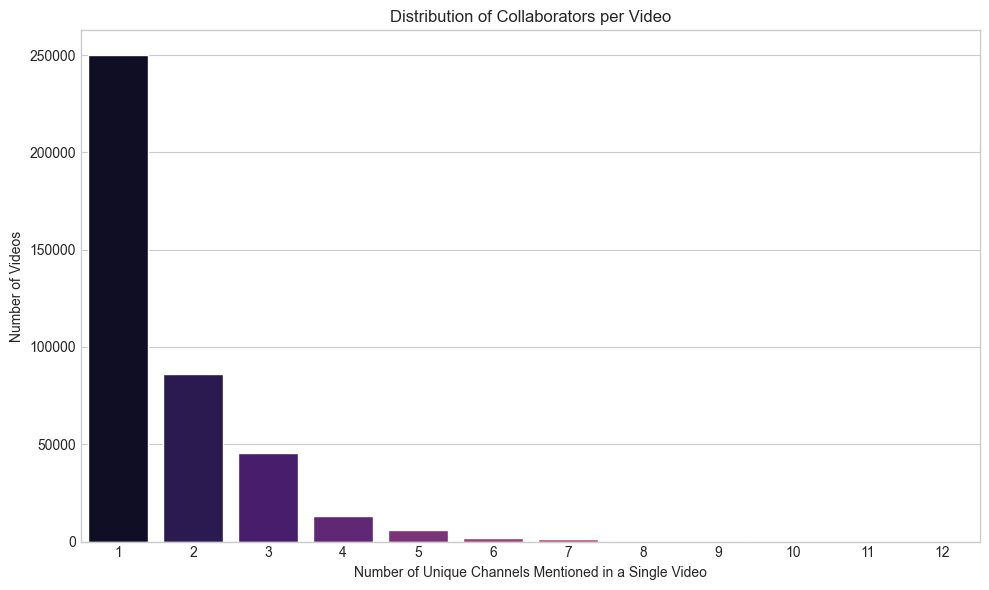


[Collaboration Leaderboards (Unfiltered)]

--- Top 10 Channels by Total Mentions (Made + Received) ---


login      display_name  follower_count  total_mentions  \
1717      deadbydaylight    DeadByDaylight         517,887            2287   
34110      ottomus_prime     Ottomus_Prime           6,895             778   
201     starforgesystems  StarforgeSystems         127,221             752   
4164              crytek            Crytek         108,297             671   
6995          advancedgg        ADVANCEDgg          13,498             652   
719           tvgnobrega        TvgNobrega          11,807             644   
139460   enzothen3philim   ENZOtheN3PHILIM           1,152             611   
60044      d2checkpoints     D2Checkpoints          62,655             611   
139495        nitebadazz        NiteBadazz             443             596   
22213     fukamishiranui             深海不知火             201             587   

        mentions_made  mentions_received  
1717                0               2287  
34110             755                 23  
201                 0                752  
4164                4                667  
6995                0                652  
719               637                  7  
139460            450                161  
60044             371                240  
139495            594                  2  
22213             456                131


--- Top 10 Channels by Unique Collaborators (Degree) ---


login    display_name  follower_count  unique_collaborators  \
9616            twitch          Twitch       2,391,682                   168   
51070   gamersoutreach  GamersOutreach          12,292                   165   
1717    deadbydaylight  DeadByDaylight         517,887                   156   
55399   gamesdonequick  GamesDoneQuick       2,067,492                   123   
5582    lagerta_seeman  Lagerta_Seeman          12,316                   110   
3332       speedgaming     SpeedGaming         149,940                    93   
16340     susume_reiki    susume_reiki           1,002                    81   
13531           maeiyo          maeiyo           1,246                    79   
142434        ruvtfest        RUVTFEST             379                    72   
1684     unknownorchid   unknownorchid           9,185                    65   

        total_mentions  
9616               551  
51070              465  
1717              2287  
55399              134  
5582               294  
3332               211  
16340              166  
13531              142  
142434             188  
1684               201

In [17]:
# %%
# Cell: Deeper Collaboration Analysis

if 'mentions_df' in locals() and not mentions_df.empty and 'channels_df' in locals() and not channels_df.empty:
    print("\n--- Deeper Collaboration Statistics ---")

    # --- 1. What percent of channels have 0 collaborations? ---
    print("\n[Network Participation]")
    total_channels = len(channels_df)
    source_channels = set(mentions_df['source_channel_id'])
    target_channels = set(mentions_df['target_channel_id'])
    collaborating_channel_ids = source_channels.union(target_channels)
    num_collaborating_channels = len(collaborating_channel_ids)
    num_zero_collabs = total_channels - num_collaborating_channels
    percent_zero_collabs = (num_zero_collabs / total_channels) * 100 if total_channels > 0 else 0

    print(f"Total channels in database: {total_channels}")
    print(f"Channels with at least one collaboration (as source or target): {num_collaborating_channels}")
    print(f"Channels with zero collaborations: {num_zero_collabs} ({percent_zero_collabs:.1f}%)")

    # --- 2. Among channels with collaborations, what percent of their videos are collaborations? ---
    print("\n[Collaboration Content Strategy]")
    total_video_counts = videos_df[videos_df['channel_id'].isin(collaborating_channel_ids)]['channel_id'].value_counts()
    collab_video_counts = mentions_df.groupby('source_channel_id')['video_id'].nunique()

    collab_stats_df = pd.DataFrame({'total_videos': total_video_counts, 'collab_videos': collab_video_counts}).fillna(0)
    collab_stats_df = collab_stats_df[collab_stats_df['total_videos'] > 0] # Avoid division by zero
    collab_stats_df['collab_video_percentage'] = (collab_stats_df['collab_videos'] / collab_stats_df['total_videos']) * 100

    median_percentage = collab_stats_df['collab_video_percentage'].median()
    mean_percentage = collab_stats_df['collab_video_percentage'].mean()
    print(f"Among channels that collaborate, the median channel has {median_percentage:.2f}% of their videos containing mentions.")
    print(f"The mean percentage of videos containing mentions is {mean_percentage:.2f}%.")

    # --- 3. Distribution of number of collaborators in a single collaboration (video) ---
    print("\n[Collaboration Size Distribution]")
    collabs_per_video = mentions_df.groupby('video_id')['target_channel_id'].nunique()

    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=collabs_per_video, order=collabs_per_video.value_counts().index, palette='magma')
    ax.set_title('Distribution of Collaborators per Video')
    ax.set_xlabel('Number of Unique Channels Mentioned in a Single Video')
    ax.set_ylabel('Number of Videos')
    # Limit x-axis for readability if there are extreme outliers
    if collabs_per_video.max() > 15:
        ax.set_xlim(-1, 15)
        ax.text(0.98, 0.98, 'Note: X-axis limited to 15 for readability', transform=ax.transAxes, ha='right', va='top')
    plt.tight_layout()
    plt.show()

    # --- 4 & 5. Top channels by total collaborations and unique collaborators ---
    # Prepare data for both stats
    mentions_made = mentions_df['source_channel_id'].value_counts().rename('mentions_made')
    mentions_received = mentions_df['target_channel_id'].value_counts().rename('mentions_received')

    if 'G_full_for_viz' in locals() and G_full_for_viz.number_of_nodes() > 0:
        full_degree = pd.Series(dict(G_full_for_viz.degree()), name='unique_collaborators')
    else: # Fallback if full graph not built yet
        G_full_temp = nx.from_pandas_edgelist(collab_df_full, 'channel_id_1', 'channel_id_2')
        full_degree = pd.Series(dict(G_full_temp.degree()), name='unique_collaborators')

    # Combine into a single DataFrame
    leaderboard_df = pd.concat([mentions_made, mentions_received, full_degree], axis=1).fillna(0).astype(int)
    leaderboard_df['total_mentions'] = leaderboard_df['mentions_made'] + leaderboard_df['mentions_received']

    # Merge with channel names
    leaderboard_df = leaderboard_df.merge(channels_df[['id', 'login', 'display_name', 'follower_count']], left_index=True, right_on='id', how='left')

    print("\n[Collaboration Leaderboards (Unfiltered)]")
    print("\n--- Top 10 Channels by Total Mentions (Made + Received) ---")
    display(leaderboard_df.sort_values('total_mentions', ascending=False).head(10)[
        ['login', 'display_name', 'follower_count', 'total_mentions', 'mentions_made', 'mentions_received']
    ])

    print("\n--- Top 10 Channels by Unique Collaborators (Degree) ---")
    display(leaderboard_df.sort_values('unique_collaborators', ascending=False).head(10)[
        ['login', 'display_name', 'follower_count', 'unique_collaborators', 'total_mentions']
    ])
else:
    print("\nMentions data or Channels data not loaded. Skipping deeper collaboration analysis.")


--- Channel Tag Analysis (on Filtered Channel Set) ---
Found 49815 unique tags across 45051 channels.

Top 20 Most Common Tags:


C:\Users\User\AppData\Local\Temp\ipykernel_24592\758362407.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='mako')
C:\Users\User\AppData\Local\Temp\ipykernel_24592\758362407.py:35: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_24592\758362407.py:35: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_24592\758362407.py:35: UserWarning: Glyph 35486 (\N{CJK UNIFIED IDEOGRAPH-8A9E}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_24592\758362407.py:35: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) Arial.
  plt.tig

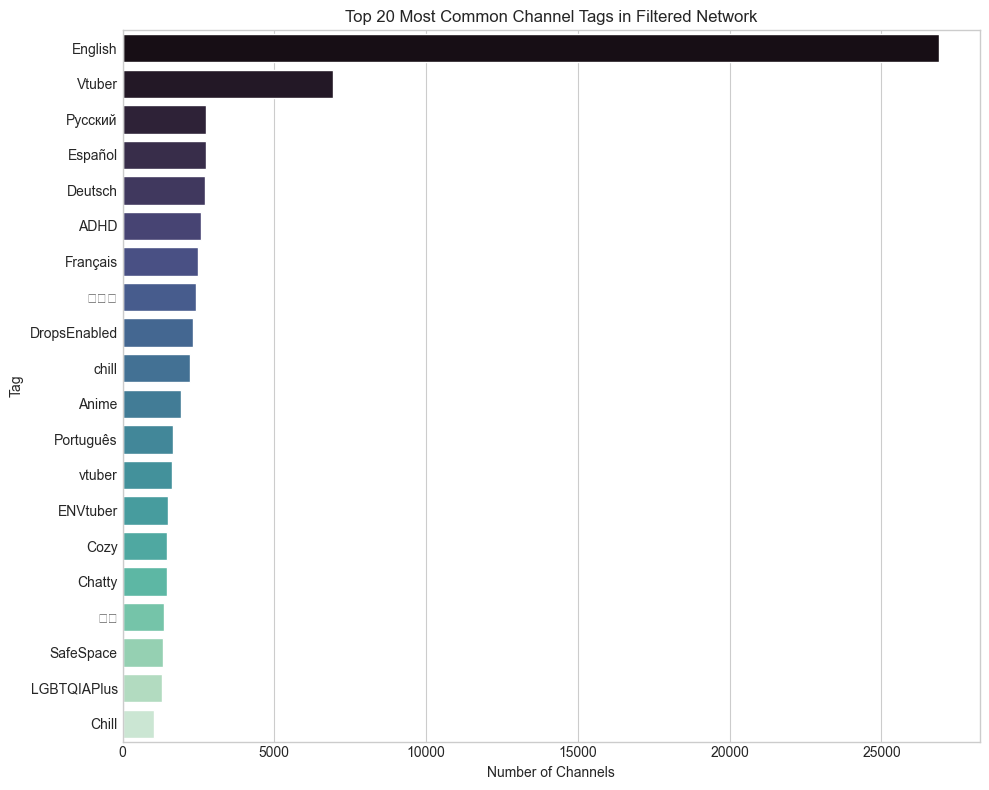

In [18]:
# %%
# Cell: Data Exploration - Channel Tags

print("\n--- Channel Tag Analysis (on Filtered Channel Set) ---")

if 'channels_df_net' in locals() and not channels_df_net.empty and 'tags' in channels_df_net.columns:
    # The 'tags' column is a JSON string, so we need to parse it.
    # We'll also handle potential errors or empty/null entries.
    def parse_tags(tags_json):
        if pd.isna(tags_json):
            return []
        try:
            return json.loads(tags_json)
        except (json.JSONDecodeError, TypeError):
            return []

    # Explode the DataFrame so each tag gets its own row
    tags_series = channels_df_net['tags'].apply(parse_tags)
    all_tags = tags_series.explode().dropna()

    if not all_tags.empty:
        print(f"Found {all_tags.nunique()} unique tags across {len(channels_df_net)} channels.")

        top_n_tags = 20
        tag_counts = all_tags.value_counts().nlargest(top_n_tags)

        print(f"\nTop {top_n_tags} Most Common Tags:")

        # Visualize the top tags
        plt.figure(figsize=(10, 8))
        sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='mako')
        plt.title(f'Top {top_n_tags} Most Common Channel Tags in Filtered Network')
        plt.xlabel('Number of Channels')
        plt.ylabel('Tag')
        plt.tight_layout()
        plt.show()
    else:
        print("No tags found to analyze in the filtered channel set.")
else:
    print("Filtered channel data (`channels_df_net`) not available or 'tags' column is missing.")

In [19]:
# Cell 13: Display Sample Filtered Collaboration Data
print("\nSample Filtered Collaboration Edges (collab_df_net):")
if not collab_df_net.empty:
    display(collab_df_net.head())
else:
    print("No collaboration data in collab_df_net (all edges filtered out or none exist).")



Sample Filtered Collaboration Edges (collab_df_net):


channel_id_1 channel_id_2  collaboration_count  \
2    457428542     63667409                    3   
4     63667409     77964394                    6   
6     42415435     63667409                    3   
7     63667409     92048793                    3   
8    149682636    274440537                    6   

   total_collaboration_duration_seconds latest_collaboration_timestamp  \
2                                 52641      2025-06-09 16:05:52+00:00   
4                                 77175      2025-06-02 12:05:34+00:00   
6                                 37866      2025-06-02 12:05:34+00:00   
7                                 37866      2025-06-02 12:05:34+00:00   
8                                 56379      2025-06-03 09:01:48+00:00   

  first_collaboration_timestamp                      last_updated  
2     2025-06-09 16:05:52+00:00  2025-06-17 16:19:11.587203+00:00  
4     2025-06-02 12:05:34+00:00  2025-06-17 16:19:20.670314+00:00  
6     2025-06-02 12:05:34+00:00  2025-06-17 16:19:11.673706+00:00  
7     2025-06-02 12:05:34+00:00  2025-06-17 16:19:11.673735+00:00  
8     2025-06-03 09:01:48+00:00  2025-06-17 16:19:43.643536+00:00

In [20]:
# Cell 14: Filtered Collaboration Network Statistics
if 'G_filtered' in locals() and G_filtered.number_of_nodes() > 0:
    print("\n--- Filtered Collaboration Network Statistics ---")
    print(f"Total Edges in Filtered Network: {G_filtered.number_of_edges()}")
    print(f"Total Nodes in Filtered Network: {G_filtered.number_of_nodes()}")

    if G_filtered.number_of_nodes() > 0:
        degree_sequence = [d for n, d in G_filtered.degree()]
        degree_df_filtered = pd.DataFrame({'channel_id': list(G_filtered.nodes()), 'degree': degree_sequence})

        print("\nDegree Distribution Summary (Filtered Network):")
        print(degree_df_filtered['degree'].describe())

        # Merge with channel names for context
        channels_for_labels_df = channels_df[['id', 'login', 'display_name']].rename(columns={'id': 'channel_id'})
        degree_df_filtered = pd.merge(degree_df_filtered, channels_for_labels_df, on='channel_id', how='left')

        print("\nTop 10 Channels by Degree (Filtered Network):")
        print(degree_df_filtered.nlargest(10, 'degree'))
    else:
        print("Filtered graph has no nodes to calculate degree.")

    # Summary for edges in collab_df_net
    if not collab_df_net.empty:
        print("\nCollaboration Count per Edge Summary (Filtered Network):")
        print(collab_df_net['collaboration_count'].describe())

        # --- Human-Readable Duration Summary ---
        print("\nTotal Collaboration Duration per Edge Summary (Filtered Network):")
        duration_stats = collab_df_net['total_collaboration_duration_seconds'].describe()

        # Create and print a formatted summary
        formatted_stats = {
            'count': f"{duration_stats['count']:.0f}",
            'mean': format_seconds_to_hm(duration_stats['mean']),
            'std dev': f"~{format_seconds_to_hm(duration_stats['std'])}",
            'min': format_seconds_to_hm(duration_stats['min']),
            '25%': format_seconds_to_hm(duration_stats['25%']),
            '50% (median)': format_seconds_to_hm(duration_stats['50%']),
            '75%': format_seconds_to_hm(duration_stats['75%']),
            'max': format_seconds_to_hm(duration_stats['max'])
        }

        for key, value in formatted_stats.items():
            # Left-align the key, right-align the value for clean output
            print(f"{key:<15} {value:>15}")

    else:
        print("No edges in collab_df_net to summarize.")
else:
    print("\nFiltered graph G_filtered is empty. No statistics to display.")


--- Filtered Collaboration Network Statistics ---
Total Edges in Filtered Network: 24561
Total Nodes in Filtered Network: 45051

Degree Distribution Summary (Filtered Network):
count   45,051
mean         1
std          2
min          0
25%          0
50%          0
75%          1
max         41
Name: degree, dtype: float64

Top 10 Channels by Degree (Filtered Network):
     channel_id  degree           login    display_name
121    91067577      41           emiru           Emiru
3644      12826      37          twitch          Twitch
825    16064695      32       dhalucard       Dhalucard
2173  106729827      32           rusty           RUSTY
2183  233825509      31  lagerta_seeman  Lagerta_Seeman
3552  106009776      29   stackupdotorg   StackUpDotOrg
2135  212360430      28           chloe           CHLOE
303    23179441      27        strippin        Strippin
2005   95645837      27        tiankami        TianKami
555    43204993      24         lilaggy         LilAggy

Collabora


--- Filtered Collaboration Network Visualizations ---
Generating Degree Distribution Histogram for the filtered network...


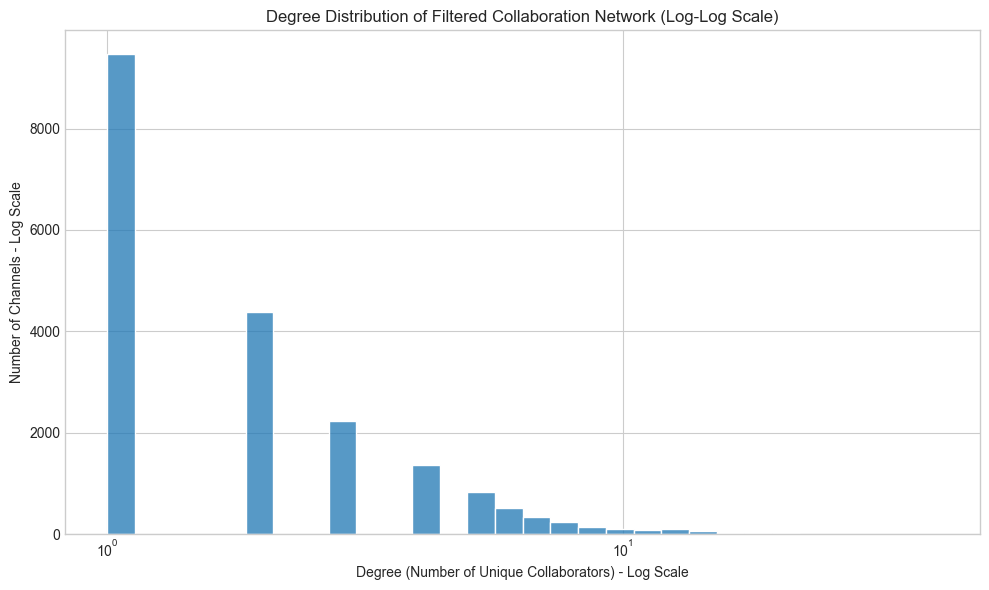

2025-08-29 17:19:10,580 - INFO - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\User\AppData\Local\Temp\ipykernel_24592\893932636.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=collab_counts_filtered, palette='viridis', order = sorted(collab_counts_filtered.unique()))
2025-08-29 17:19:10,629 - INFO - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Generating Edge Weight (Collaboration Count) Plot...


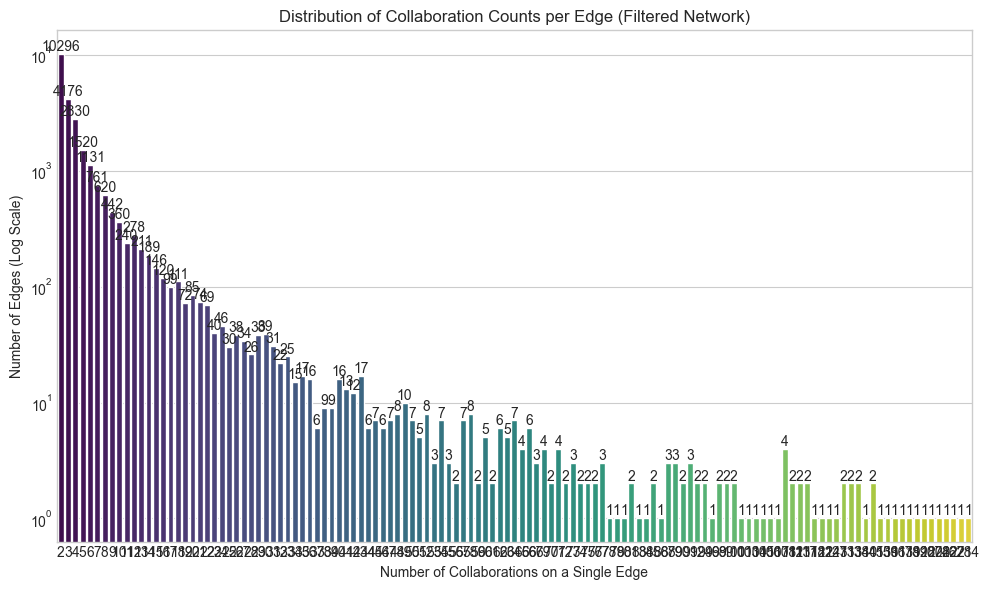

In [21]:
# Cell 15: Filtered Collaboration Network Visualizations
if 'G_filtered' in locals() and G_filtered.number_of_nodes() > 0 and 'degree_df_filtered' in locals() and not degree_df_filtered.empty:
    print("\n--- Filtered Collaboration Network Visualizations ---")

    # --- 1. Degree Distribution Histogram ---
    print("Generating Degree Distribution Histogram for the filtered network...")
    plt.figure(figsize=(10, 6))

    degrees_filtered = degree_df_filtered[degree_df_filtered['degree'] > 0]['degree']
    if not degrees_filtered.empty:
        # Log-log scale is common for degree distributions to check for power-law behavior
        sns.histplot(degrees_filtered, log_scale=True, bins=30)
        plt.title('Degree Distribution of Filtered Collaboration Network (Log-Log Scale)')
        plt.xlabel('Degree (Number of Unique Collaborators) - Log Scale')
        plt.ylabel('Number of Channels - Log Scale')
        plt.tight_layout()
        plt.show()
    else:
        print("No nodes with degree > 0 found to plot.")

    # --- 2. Edge Weight (Collaboration Count) Plot ---
    if not collab_df_net.empty:
        print("\nGenerating Edge Weight (Collaboration Count) Plot...")
        plt.figure(figsize=(10, 6))

        collab_counts_filtered = collab_df_net[collab_df_net['collaboration_count'] > 0]['collaboration_count']

        if not collab_counts_filtered.empty:
            # A countplot is more direct and robust for this type of discrete integer data
            ax = sns.countplot(x=collab_counts_filtered, palette='viridis', order = sorted(collab_counts_filtered.unique()))

            # Add text labels on top of each bar
            for p in ax.patches:
                ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points')

            plt.title('Distribution of Collaboration Counts per Edge (Filtered Network)')
            plt.xlabel('Number of Collaborations on a Single Edge')

            # Conditionally apply log scale to y-axis only if counts are high
            max_count = collab_counts_filtered.value_counts().max()
            if max_count > 10:
                plt.yscale('log')
                plt.ylabel('Number of Edges (Log Scale)')
            else:
                plt.ylabel('Number of Edges (Linear Scale)')

            plt.tight_layout()
            plt.show()
        else:
            print("No collaborations with count > 0 found to plot.")

else:
    print("\nFiltered graph or degree data insufficient for visualization. Skipping.")

## Community Detection in Collaboration Network

In [22]:
# %%
# Cell: Helper function for Community Naming via Characteristic Tags

import numpy as np # For log calculation

def get_community_labels(channels_df, partition):
    """
    Generates a name for each community based on its most "characteristic" tags.
    A characteristic tag is one that is frequent within the community but relatively
    rare in the overall network (TF-IDF inspired).
    """
    print("Generating community names based on characteristic tags...")
    community_labels = {}

    # Get a mapping of community ID to its list of member channel IDs
    communities = {}
    for channel_id, community_id in partition.items():
        if community_id not in communities:
            communities[community_id] = []
        communities[community_id].append(channel_id)

    # Prepare tag data
    channels_with_tags = channels_df[channels_df['id'].isin(partition.keys())].copy()
    channels_with_tags['tags_list'] = channels_with_tags['tags'].apply(
        lambda x: json.loads(x) if pd.notna(x) else []
    )

    # Calculate global tag frequencies (how many channels have a given tag)
    all_tags_exploded = channels_with_tags['tags_list'].explode()
    global_tag_counts = all_tags_exploded.value_counts()

    total_channels_in_network = len(channels_with_tags)

    for cid, members in communities.items():
        if cid == -1: continue # Skip outlier community

        community_channels = channels_with_tags[channels_with_tags['id'].isin(members)]

        # Get all tags within this specific community
        community_tags_exploded = community_channels['tags_list'].explode()

        if community_tags_exploded.dropna().empty:
            community_labels[cid] = f"Community {cid} (No Tags)"
            continue

        # Calculate local frequency (TF) for tags within this community
        local_tag_counts = community_tags_exploded.value_counts()

        # Calculate characteristic score for each tag in the community
        tag_scores = {}
        for tag, local_count in local_tag_counts.items():
            global_count = global_tag_counts.get(tag, 1) # Get global count, default to 1 to avoid division by zero

            # TF-IDF-like score: (frequency in community) * log(rarity in whole network)
            tf = local_count / len(community_tags_exploded)
            idf = np.log(total_channels_in_network / global_count)
            tag_scores[tag] = tf * idf

        # Get the top 3 tags with the highest characteristic score
        if tag_scores:
            top_tags = sorted(tag_scores.items(), key=lambda item: item[1], reverse=True)[:3]
            community_name = ", ".join([tag for tag, score in top_tags])
            community_labels[cid] = community_name
        else:
            community_labels[cid] = f"Community {cid}"

    print("Community names generated.")
    return community_labels

In [23]:
# %%
# Cell: Community Detection Setup and Execution

import community as community_louvain # python-louvain library

communities_detected = False
partition = {} # Ensure partition is defined
communities = {} # Ensure communities is defined
community_labels = {} # Ensure labels dict is defined

if 'G_filtered' in locals() and G_filtered.number_of_nodes() > 0:
    print(f"\n--- Performing Louvain Community Detection on FILTERED graph at {datetime.now().strftime('%H:%M:%S')} ---")
    print(f"Using 'collaboration_count' as edge weight for community detection.")

    # Ensure 'weight' attribute is set for Louvain
    for u, v, data in G_filtered.edges(data=True):
        if 'weight' not in data:
            G_filtered.edges[u,v]['weight'] = data.get('collaboration_count', 1)

    start_time_community = time.time()
    try:
        partition = community_louvain.best_partition(G_filtered, weight='weight', random_state=42)
        modularity = community_louvain.modularity(partition, G_filtered, weight='weight')

        # Group nodes by community ID
        for node, community_id in partition.items():
            if community_id not in communities: communities[community_id] = []
            communities[community_id].append(node)

        num_communities = len(communities)
        print(f"Louvain Community Detection complete in {time.time() - start_time_community:.2f}s.")
        print(f"Found {num_communities} communities.")
        print(f"Modularity of the partition: {modularity:.4f}")

        # This uses the helper function which should now be in a preceding cell.
        if 'get_community_labels' in locals():
            community_labels = get_community_labels(channels_df_net, partition)
        else:
            print("\nWarning: get_community_labels function not defined yet. Skipping tag-based naming.")

        # Analyze and print top communities with their new names
        sorted_communities_by_size = sorted(communities.items(), key=lambda item: len(item[1]), reverse=True)

        print("\n--- Top 5 Largest Communities ---")
        for i in range(min(5, len(sorted_communities_by_size))):
            cid, nodes = sorted_communities_by_size[i]

            # Get the new tag-based name for this community
            community_name = community_labels.get(cid, f"Community {cid}")

            # Get channel names for a few members
            member_names = [
                channels_for_labels_df.loc[channels_for_labels_df['channel_id'] == node_id, 'login'].iloc[0]
                for node_id in nodes[:3]
                if not channels_for_labels_df[channels_for_labels_df['channel_id'] == node_id].empty
            ]

            # Print the enhanced summary
            print(f"\n  Community {cid} (Size rank {i+1}): {len(nodes)} members.")
            print(f"    -> Characteristic Tags: {community_name}")
            print(f"    -> Example Members: {', '.join(member_names[:3])}...")

        communities_detected = True

    except Exception as e:
        print(f"Error during community detection: {e}")
        logging.error("Community detection error", exc_info=True)
else:
    print("\nFiltered graph G_filtered not found or is empty. Skipping community detection.")


--- Performing Louvain Community Detection on FILTERED graph at 17:19:14 ---
Using 'collaboration_count' as edge weight for community detection.
Louvain Community Detection complete in 10.44s.
Found 27792 communities.
Modularity of the partition: 0.9727
Generating community names based on characteristic tags...
Community names generated.

--- Top 5 Largest Communities ---

  Community 38 (Size rank 1): 565 members.
    -> Characteristic Tags: English, deadbydaylight, dbd
    -> Example Members: mish, aciixx, femba...

  Community 2 (Size rank 2): 526 members.
    -> Characteristic Tags: Deutsch, german, DropsAktiviert
    -> Example Members: tolkin, karni, noway4u_sir...

  Community 12 (Size rank 3): 508 members.
    -> Characteristic Tags: IRL, English, DropsEnabled
    -> Example Members: hachubby, studytme, primroze...

  Community 4 (Size rank 4): 457 members.
    -> Characteristic Tags: Vtuber, vtuber, Anime
    -> Example Members: okcode, sayu, yozora...

  Community 7 (Size ra

In [24]:
# %%
# Cell: Influential Channel Analysis

if 'G_filtered' in locals() and G_filtered.number_of_nodes() > 0:
    print("\n--- Analyzing Influential Channels in the Filtered Network ---")

    # --- 1. Calculate PageRank Score for the Overall Graph ---
    # We now only calculate PageRank, which is much faster.
    print("Calculating PageRank for the overall graph...")
    start_time_centrality = time.time()

    # Using collaboration_count as weight makes the scores more meaningful
    pagerank_scores = nx.pagerank(G_filtered, weight='collaboration_count')

    print(f" -> PageRank calculation complete in {time.time() - start_time_centrality:.2f}s.")

    # --- 2. Combine Scores into a single, rich DataFrame ---
    centrality_df = degree_df_filtered.copy() # Start with degree and names
    centrality_df['pagerank'] = centrality_df['channel_id'].map(pagerank_scores)

    # Merge with the main channels_df to get follower counts
    centrality_df = pd.merge(
        centrality_df,
        channels_df[['id', 'follower_count']],
        left_on='channel_id',
        right_on='id',
        how='left'
    ).drop(columns=['id'])

    # --- 3. Report Top Channels - Overall Network ---
    print("\n" + "="*60)
    print("--- Top 10 Most Influential Channels (Overall) by PageRank ---")
    print("PageRank measures influence based on connections to other influential channels.")
    # Display without the 'betweenness' column
    display(centrality_df.sort_values('pagerank', ascending=False).head(10)[
        ['login', 'display_name', 'degree', 'follower_count', 'pagerank']
    ])
    print("="*60)

    # --- 4. Report Top Channels - Within Each Top Community ---
    print("\n\n--- Most Influential Channels within Top Communities (by PageRank) ---")
    if 'sorted_communities_by_size' in locals() and community_labels:
        # Iterate through the top 5 communities we found and named earlier
        for i in range(min(5, len(sorted_communities_by_size))):
            cid, nodes = sorted_communities_by_size[i]
            community_name = community_labels.get(cid, f"Community {cid}")

            print(f"\n- Community {i+1}: '{community_name}' ({len(nodes)} members)")

            # Create a subgraph containing only the nodes of this community
            community_subgraph = G_filtered.subgraph(nodes)

            if community_subgraph.number_of_nodes() > 1:
                # Calculate PageRank *within this community only*
                pagerank_community = nx.pagerank(community_subgraph, weight='collaboration_count')

                # Get the centrality_df rows for members of this community
                community_centrality_df = centrality_df[centrality_df['channel_id'].isin(nodes)].copy()

                # Map the *intra-community* PageRank score
                community_centrality_df['pagerank_in_community'] = community_centrality_df['channel_id'].map(pagerank_community)

                # Display the top 3 most influential channels *for this community*
                display(community_centrality_df.sort_values('pagerank_in_community', ascending=False).head(3)[
                    ['login', 'display_name', 'degree', 'follower_count', 'pagerank_in_community']
                ])
            else:
                print("  (Community is too small to analyze for internal influence)")
    else:
        print("Community data not available to perform per-community analysis.")
else:
    print("\nFiltered graph is empty. Skipping centrality analysis.")


--- Analyzing Influential Channels in the Filtered Network ---
Calculating PageRank for the overall graph...
 -> PageRank calculation complete in 0.38s.

--- Top 10 Most Influential Channels (Overall) by PageRank ---
PageRank measures influence based on connections to other influential channels.


login    display_name  degree  follower_count  pagerank
3644          twitch          Twitch      37       2,391,682         0
3552   stackupdotorg   StackUpDotOrg      29          17,396         0
780           elfyou          elfyou      22          23,580         0
87            itmejp          itmeJP      23         371,828         0
2135           chloe           CHLOE      28          21,182         0
121            emiru           Emiru      41       1,848,882         0
2183  lagerta_seeman  Lagerta_Seeman      31          12,316         0
106            arrav           Arrav      17          33,258         0
825        dhalucard       Dhalucard      32         559,373         0
1128         ollybot         OllyBOT      23          27,861         0



--- Most Influential Channels within Top Communities (by PageRank) ---

- Community 1: 'English, deadbydaylight, dbd' (565 members)


login display_name  degree  follower_count  pagerank_in_community
780    elfyou       elfyou      22          23,580                      0
1128  ollybot      OllyBOT      23          27,861                      0
273      mish         Mish      18         129,708                      0


- Community 2: 'Deutsch, german, DropsAktiviert' (526 members)


login    display_name  degree  follower_count  \
825        dhalucard       Dhalucard      32         559,373   
1055  behaartmitbart  BehaartMitBart      16          46,019   
50         metashi12       metashi12      18         323,326   

      pagerank_in_community  
825                       0  
1055                      0  
50                        0


- Community 3: 'IRL, English, DropsEnabled' (508 members)


login display_name  degree  follower_count  pagerank_in_community
106    arrav        Arrav      17          33,258                      0
121    emiru        Emiru      41       1,848,882                      0
564  vangard      Vangard      13          17,478                      0


- Community 4: 'Vtuber, vtuber, Anime' (457 members)


login    display_name  degree  follower_count  \
1919  chachayourvmom  ChaChaYourVmom      21         110,600   
1917       minikomew       MinikoMew      15          64,306   
2790     reksongames     ReksonGames      16          24,391   

      pagerank_in_community  
1919                      0  
1917                      0  
2790                      0


- Community 5: 'Vtuber, ADHD, ENVtuber' (358 members)


login  display_name  degree  follower_count  \
4733  cherriglitch  CherriGlitch      18           6,651   
5937   adora_bunny   Adora_Bunny      19          24,081   
5939     hulkykrow     HulkyKrow      11           1,840   

      pagerank_in_community  
4733                      0  
5937                      0  
5939                      0

### Visualizing Communities


--- NetworkX Subgraph Visualization with Community Colors & Labels ---
Generating community names based on characteristic tags...
Community names generated.
Creating subgraph visualization with 833 nodes...


C:\Users\User\AppData\Local\Temp\ipykernel_24592\3062006298.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_colors) if num_colors <= 20 else plt.cm.get_cmap('viridis', num_colors)
C:\Users\User\AppData\Local\Temp\ipykernel_24592\3062006298.py:73: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) Arial.
  plt.axis('off'); plt.tight_layout(); plt.show()
C:\Users\User\AppData\Local\Temp\ipykernel_24592\3062006298.py:73: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) Arial.
  plt.axis('off'); plt.tight_layout(); plt.show()
C:\Users\User\AppData\Local\Temp\ipykernel_24592\3062006298.py:73: UserWarning: Glyph 35486 (\N{CJK UNIFIED IDEOGRAPH-8A9E}) missing from font(s) Arial.
  plt.axis('off'); plt.tight_layout(); plt

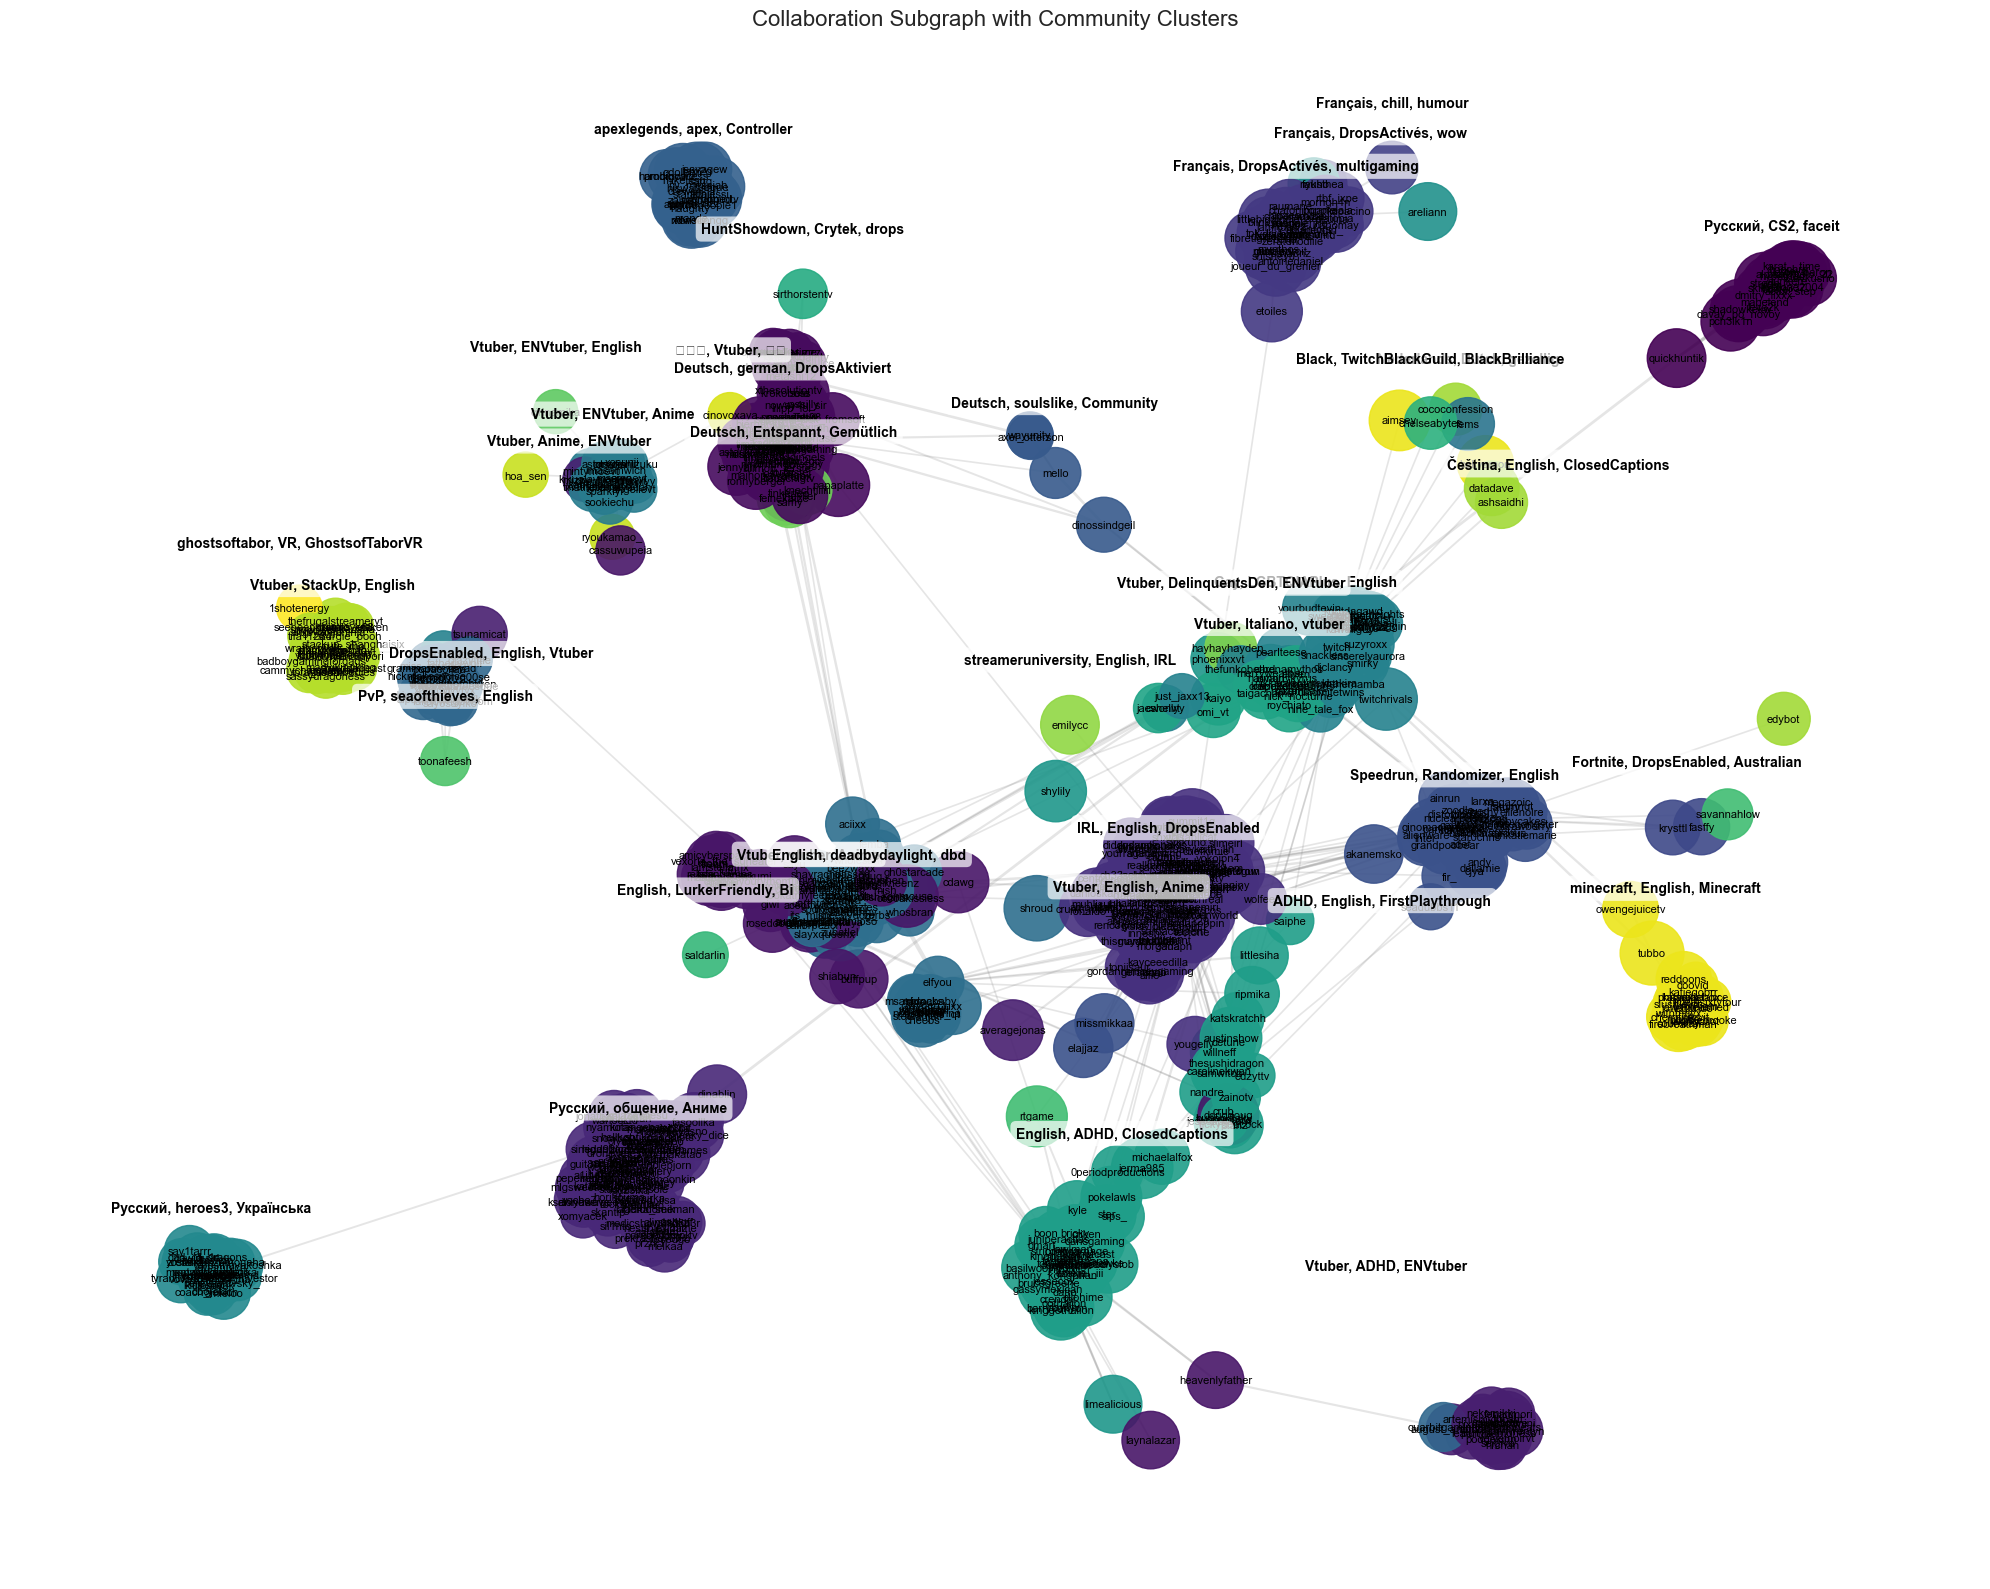

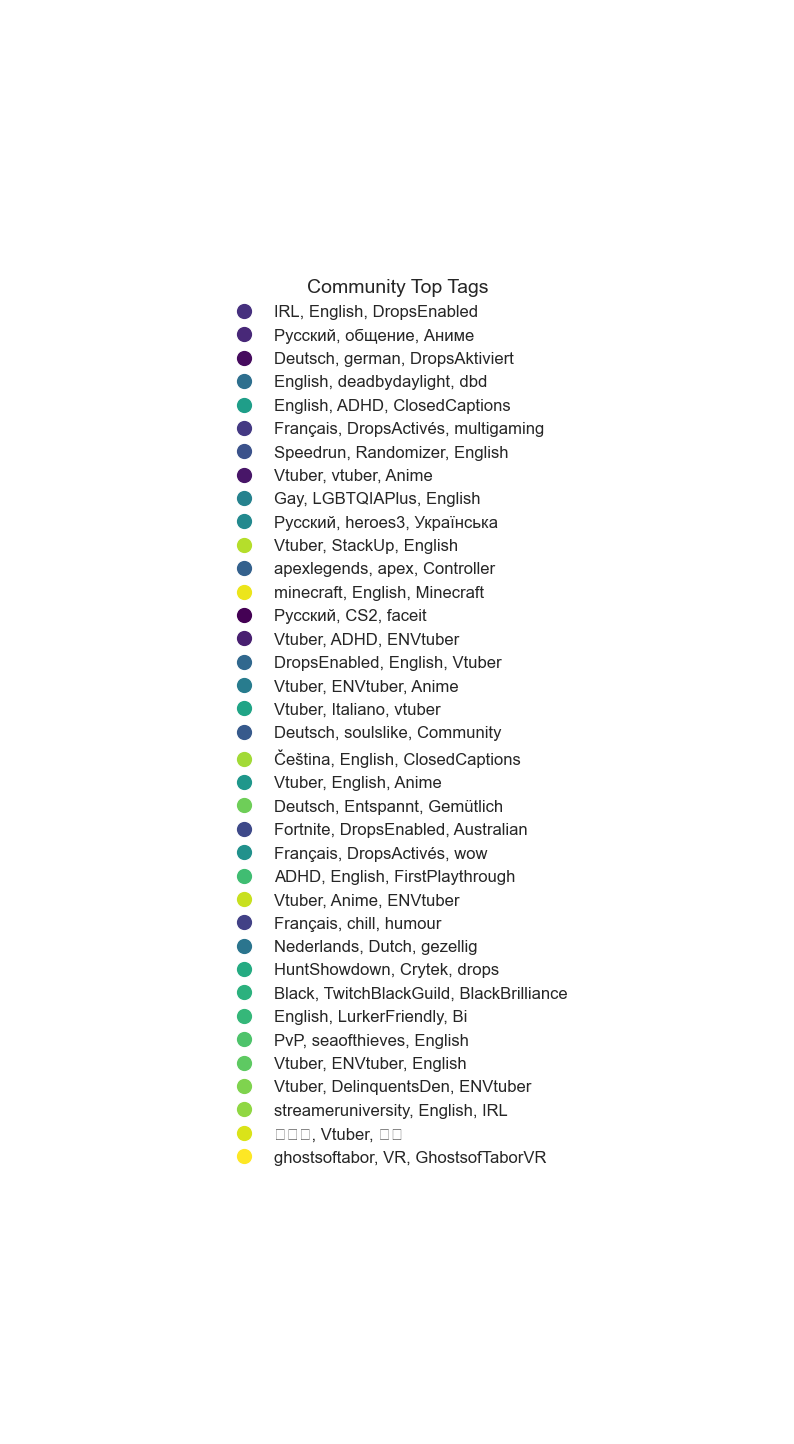

In [25]:
# %%
# Cell: Visualize Subgraph with Community Colors (with Labels and Legend)

from matplotlib.lines import Line2D # Needed for custom legend
import numpy as np # Needed for centroid calculation

if communities_detected and 'G_filtered' in locals() and G_filtered.number_of_nodes() > 0:
    print("\n--- NetworkX Subgraph Visualization with Community Colors & Labels ---")
    try:
        # --- 1. Generate Community Labels using our helper function ---
        community_labels = get_community_labels(channels_df_net, partition)

        # --- 2. Create the subgraph for visualization ---
        top_nodes_filtered = degree_df_filtered.nlargest(config.NETWORK_VIZ_TOP_N_CHANNELS_BY_DEGREE, 'degree')['channel_id'].tolist()
        subgraph_nodes_set = set(top_nodes_filtered)
        max_subgraph_nodes = config.NETWORK_VIZ_MAX_SUBGRAPH_NODES

        for node in list(subgraph_nodes_set):
            if G_filtered.has_node(node) and len(subgraph_nodes_set) < max_subgraph_nodes:
                neighbors = list(G_filtered.neighbors(node));
                subgraph_nodes_set.update(neighbors[:max_subgraph_nodes - len(subgraph_nodes_set)])

        subgraph = G_filtered.subgraph(list(subgraph_nodes_set))
        print(f"Creating subgraph visualization with {subgraph.number_of_nodes()} nodes...")

        if subgraph.number_of_nodes() > 0:
            # --- 3. Use community-clustered layout ---
            layout_graph = subgraph.copy()
            for u, v in layout_graph.edges():
                if partition.get(u) == partition.get(v): layout_graph.edges[u,v]['weight'] = 5
                else: layout_graph.edges[u,v]['weight'] = 0.1
            pos_subgraph = nx.spring_layout(layout_graph, weight='weight', k=0.4, iterations=50, seed=42)

            # --- 4. Prepare Visual Properties (Colors, Sizes, etc.) ---
            # THIS IS THE ONE TRUE COLOR MAP AND INDEXING
            unique_community_ids_in_subgraph = sorted(list(set(partition[node] for node in subgraph.nodes() if node in partition)))
            community_to_color_idx = {cid: i for i, cid in enumerate(unique_community_ids_in_subgraph)}
            num_colors = len(unique_community_ids_in_subgraph)
            cmap = plt.cm.get_cmap('tab20', num_colors) if num_colors <= 20 else plt.cm.get_cmap('viridis', num_colors)

            node_colors = [cmap(community_to_color_idx.get(partition.get(node), -1)) for node in subgraph.nodes()]
            node_data_subgraph = channels_df[channels_df['id'].isin(subgraph.nodes())].set_index('id')
            node_sizes = [math.log10(max(1, node_data_subgraph.loc[node,'follower_count'] if node in node_data_subgraph.index else 1)+1) * 300 + 100 for node in subgraph.nodes()]
            node_labels = pd.merge(pd.DataFrame({'channel_id': list(subgraph.nodes())}), channels_for_labels_df, on='channel_id', how='left').set_index('channel_id')['login'].to_dict()
            edge_widths = [math.log10(max(0, d.get('collaboration_count',0)) + 1) * 1.5 + 0.5 for u, v, d in subgraph.edges(data=True)]

            # --- 5. Drawing the Graph ---
            plt.figure(figsize=(20, 16))
            ax = plt.gca()

            nx.draw_networkx_nodes(subgraph, pos_subgraph, node_size=node_sizes, node_color=node_colors, alpha=0.9, ax=ax)
            nx.draw_networkx_edges(subgraph, pos_subgraph, width=edge_widths, alpha=0.2, edge_color='gray', ax=ax)
            nx.draw_networkx_labels(subgraph, pos_subgraph, labels=node_labels, font_size=8, ax=ax)

            # --- 6. Draw the community labels (centroids) on the graph ---
            community_centroids = {}
            for cid in unique_community_ids_in_subgraph:
                if cid != -1:
                    community_nodes_in_subgraph = [node for node in subgraph.nodes() if partition.get(node) == cid]
                    if community_nodes_in_subgraph:
                        x_coords = [pos_subgraph[node][0] for node in community_nodes_in_subgraph]
                        y_coords = [pos_subgraph[node][1] for node in community_nodes_in_subgraph]
                        community_centroids[cid] = (np.mean(x_coords), np.mean(y_coords))

            for cid, pos in community_centroids.items():
                label_text = community_labels.get(cid, "")
                ax.text(pos[0], pos[1] + 0.08, s=label_text,
                        horizontalalignment='center',
                        fontdict={'size': 10, 'color': 'black', 'weight': 'bold'},
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.4'))

            plt.title('Collaboration Subgraph with Community Clusters', fontsize=16)
            plt.axis('off'); plt.tight_layout(); plt.show()

            # --- 7. Generate a separate, clean legend ---
            # THIS SECTION IS NOW CORRECTED
            communities_in_subgraph_sorted = sorted(
                unique_community_ids_in_subgraph,
                key=lambda cid: len([n for n in subgraph.nodes() if partition.get(n) == cid]),
                reverse=True
            )

            legend_elements = []
            # We now use the SAME cmap and community_to_color_idx from step 4
            for cid in communities_in_subgraph_sorted:
                if cid == -1:
                    label = "Outliers"
                    color = 'grey'
                else:
                    label = community_labels.get(cid, f"Community {cid}")
                    # Use the correct color mapping
                    color = cmap(community_to_color_idx.get(cid))

                legend_elements.append(Line2D([0], [0], marker='o', color='w',
                                              label=f'{label}',
                                              markerfacecolor=color, markersize=12))
            if legend_elements:
                fig_legend, ax_legend = plt.subplots(figsize=(10, len(legend_elements) * 0.5))
                ax_legend.legend(handles=legend_elements, title="Community Top Tags", loc='center', fontsize=12, title_fontsize=14)
                ax_legend.axis('off')
                plt.show()

    except Exception as e:
        print(f"An error occurred during community visualization: {e}")
        logging.error("Community visualization error", exc_info=True)

else:
    print("\nNo communities detected or filtered graph is empty. Skipping community visualization.")

# Collaboration Topic Modeling with BERTopic

Here, we derive context by analyzing the content of video titles. We use BERTopic to automatically discover topics from the titles of videos belonging to channels in our filtered collaboration network. This helps us understand what collaborating streamers talk about or play, without relying on pre-defined categories.


In [26]:
# %%
# Cell: BERTopic Pre-processing: Assign Topic ID to All Relevant Videos

# This cell trains the BERTopic model on a large sample of video titles,
# optionally reduces outliers, and then assigns a topic ID to each video.

# Initialize global-like variables to hold the results
topic_model = None
videos_with_topics_df = None

print("\n--- Starting Collaboration Topic Modeling with BERTopic ---")

# --- 1. Main Gate: Check if we have a filtered graph to work with ---
if 'G_filtered' in locals() and G_filtered.number_of_nodes() > 0:
    # --- 2. If graph exists, proceed with data preparation and modeling ---
    try:
        from bertopic import BERTopic
        import nltk
        from nltk.corpus import stopwords
        import re

        # Set to True to run the outlier reduction step, False to skip it.
        run_outlier_reduction = True

        # Setup NLTK stopwords
        try:
            stopwords.words('english')
        except LookupError:
            print("NLTK stopwords not found. Downloading...")
            nltk.download('stopwords')

        stop_words = set(stopwords.words('english'))
        mention_regex = re.compile(r'@([a-zA-Z0-9_]{4,25})')

        def clean_title(title):
            if not isinstance(title, str): return ""
            text = mention_regex.sub('', title)
            text = re.sub(r'[^A-Za-z0-9\s]+', '', text)
            text = text.lower()
            text = ' '.join([word for word in text.split() if word not in stop_words])
            return text

        print("Preparing data for topic modeling...")
        nodes_in_network = list(G_filtered.nodes())
        videos_for_modeling_df = videos_df[videos_df['channel_id'].isin(nodes_in_network)].copy()
        print(f"Found {len(videos_for_modeling_df)} videos from {len(nodes_in_network)} channels in the filtered network.")

        print(f"Filtering for English language videos...")
        english_videos_df = videos_for_modeling_df[videos_for_modeling_df['language'] == 'en'].copy()
        print(f" -> Found {len(english_videos_df)} English videos to model.")

        print("Cleaning video titles (removing stopwords and mentions)...")
        english_videos_df['cleaned_title'] = english_videos_df['title'].dropna().apply(clean_title)

        docs_df = english_videos_df[english_videos_df['cleaned_title'].str.len() > 0].copy()
        docs = docs_df['cleaned_title'].tolist()

        # --- 3. Check if we have enough documents to proceed ---
        if len(docs) < 50:
            print(f"Not enough video titles found ({len(docs)}) after cleaning to perform topic modeling.")

        else:
            # --- 4. This is where the actual modeling happens ---
            MAX_DOCS_FOR_MODELING = 50000
            if len(docs) > MAX_DOCS_FOR_MODELING:
                print(f"Sampling {MAX_DOCS_FOR_MODELING} titles for topic modeling to ensure performance...")
                docs_df = docs_df.sample(n=MAX_DOCS_FOR_MODELING, random_state=42)
                docs = docs_df['cleaned_title'].tolist()

            print(f"Training BERTopic model on {len(docs)} cleaned video titles. This may take several minutes...")

            topic_model = BERTopic(
                min_topic_size=20,
                verbose=True
            )

            topics, _ = topic_model.fit_transform(docs)

            topics_to_assign = topics # Default to the original topics from the model

            if run_outlier_reduction:
                print("\n--- Applying Outlier Reduction (Toggle is ON) ---")
                initial_outlier_count = (pd.Series(topics) == -1).sum()
                print(f"Initial outlier count: {initial_outlier_count} ({(initial_outlier_count/len(topics)*100):.1f}%)")

                if initial_outlier_count > 0 and initial_outlier_count < len(topics):
                    print("Reducing outliers using the 'c-tf-idf' strategy...")
                    new_topics = topic_model.reduce_outliers(docs, topics, strategy="c-tf-idf")

                    final_outlier_count = (pd.Series(new_topics) == -1).sum()
                    print(f"Outlier count after reduction: {final_outlier_count} ({(final_outlier_count/len(topics)*100):.1f}%)")
                    print(f"Successfully re-assigned {initial_outlier_count - final_outlier_count} outlier documents.")

                    # Use the new topic assignments for the rest of the analysis
                    topics_to_assign = new_topics
                else:
                    print("No outliers to reduce, or all documents were outliers.")
            else:
                print("\n--- Skipping Outlier Reduction (Toggle is OFF) ---")


            print("\nMapping topic results back to videos...")
            docs_df['topic_id'] = topics_to_assign # Use the final topic assignments
            videos_with_topics_df = docs_df

            print("\n--- BERTopic Analysis Complete ---")

            print("\nTop discovered topics from cleaned titles:")
            display(topic_model.get_topic_info())

            print("\nVisualizing top topics (barchart):")
            display(topic_model.visualize_barchart(top_n_topics=10))

            print("\nVisualizing inter-topic distance map:")
            display(topic_model.visualize_topics())

    # --- 5. Handle potential errors for the entire block ---
    except ImportError:
        print("\nCould not perform topic modeling. Please install required libraries:")
        print("pip install bertopic sentence-transformers scikit-learn nltk")
    except Exception as e:
        print(f"An error occurred during topic modeling: {e}")
        logging.error("BERTopic analysis failed", exc_info=True)
else:
    print("\nFiltered graph G_filtered not found or is empty. Skipping topic modeling.")


--- Starting Collaboration Topic Modeling with BERTopic ---
Preparing data for topic modeling...
Found 2250750 videos from 45051 channels in the filtered network.
Filtering for English language videos...
 -> Found 1262098 English videos to model.
Cleaning video titles (removing stopwords and mentions)...
Sampling 50000 titles for topic modeling to ensure performance...
Training BERTopic model on 50000 cleaned video titles. This may take several minutes...


2025-08-29 17:23:32,014 - BERTopic - Embedding - Transforming documents to embeddings.
2025-08-29 17:23:32,018 - INFO - SentenceTransformer - Use pytorch device_name: cpu
2025-08-29 17:23:32,018 - INFO - SentenceTransformer - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-08-29 17:26:38,664 - BERTopic - Embedding - Completed ✓
2025-08-29 17:26:38,665 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-29 17:27:41,896 - BERTopic - Dimensionality - Completed ✓
2025-08-29 17:27:41,898 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-29 17:27:49,447 - BERTopic - Cluster - Completed ✓
2025-08-29 17:27:49,473 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-29 17:27:50,576 - BERTopic - Representation - Completed ✓



--- Applying Outlier Reduction (Toggle is ON) ---
Initial outlier count: 23715 (47.4%)
Reducing outliers using the 'c-tf-idf' strategy...
Outlier count after reduction: 245 (0.5%)
Successfully re-assigned 23470 outlier documents.

Mapping topic results back to videos...

--- BERTopic Analysis Complete ---

Top discovered topics from cleaned titles:


Topic  Count                                 Name  \
0       -1  23715              -1_discord_day_drops_18   
1        0    798            0_clip_clips_lurk_discord   
2        1    615                1_vs_wsow_ewc_bracket   
3        2    453    2_socials_pobox_unknown_vtubereng   
4        3    453     3_giveaway_giveaways_vbucks_pass   
..     ...    ...                                  ...   
338    337     20    337_goblin_goblins_grass_touching   
339    338     20         338_1v1mecom_1v1me_match_1v1   
340    339     20         339_songlist_jam_guitar_jams   
341    340     20         340_hcim_rick_series_inferno   
342    341     20  341_kofi_borks_readathon_quadzerker   

                                        Representation  \
0    [discord, day, drops, 18, stream, socials, mer...   
1    [clip, clips, lurk, discord, vtuber, burp, 18,...   
2    [vs, wsow, ewc, bracket, stage, finals, tourna...   
3    [socials, pobox, unknown, vtubereng, 4d, yt2, ...   
4    [giveaway, giveaways, vbucks, pass, gift, gard...   
..                                                 ...   
338  [goblin, goblins, grass, touching, loot, elnoi...   
339  [1v1mecom, 1v1me, match, 1v1, vs, 1v1s, drini,...   
340  [songlist, jam, guitar, jams, jamnesday, uke, ...   
341  [hcim, rick, series, inferno, schedule, eile, ...   
342  [kofi, borks, readathon, quadzerker, wimey, ko...   

                                   Representative_Docs  
0    [never getting gold ranked w viewers console p...  
1    [watch go discord clip, morning chat discord c...  
2    [1000000 wsow group stage 100t ghost, 1000000 ...  
3    [unknown dbd unknown main socials, come hang c...  
4    [code giveaways dune, fortnite drops giveaways...  
..                                                 ...  
338  [game turn goblin, chill cozy goblin vibes lon...  
339                     [1v1mecom, 1v1mecom, 1v1mecom]  
340  [like tuesday jam songlist, jam jammin jamnesd...  
341  [hcim budget inferno attempt newvid schedule s...  
342  [l8te night grind overweebs assemble kofi, 12h...  

[343 rows x 5 columns]


Visualizing top topics (barchart):



Visualizing inter-topic distance map:


In [27]:
# Cell: Diagnostic for BERTopic Results

if 'topic_model' in locals() and topic_model is not None:
    print("--- BERTopic Model Diagnostics ---")

    # Get the overview of topics
    topic_info = topic_model.get_topic_info()

    # Check the size of the outlier topic (-1)
    outlier_info = topic_info[topic_info['Topic'] == -1]
    if not outlier_info.empty:
        total_docs = topic_info['Count'].sum()
        outlier_count = outlier_info['Count'].iloc[0]
        outlier_percentage = (outlier_count / total_docs) * 100
        print(f"\nOutlier Topic (-1) contains {outlier_count} videos ({outlier_percentage:.1f}% of the total).")

    print("\nOverview of the top 10 most frequent topics (excluding outliers):")
    display(topic_info[topic_info['Topic'] != -1].head(10))

else:
    print("BERTopic model has not been trained yet.")

--- BERTopic Model Diagnostics ---

Outlier Topic (-1) contains 23715 videos (47.4% of the total).

Overview of the top 10 most frequent topics (excluding outliers):


Topic  Count                                Name  \
1       0    798           0_clip_clips_lurk_discord   
2       1    615               1_vs_wsow_ewc_bracket   
3       2    453   2_socials_pobox_unknown_vtubereng   
4       3    453    3_giveaway_giveaways_vbucks_pass   
5       4    424           4_fish_fishing_fishy_bait   
6       5    417    5_socials_discord_yam_theacademy   
7       6    410        6_cooking_chicken_pizza_food   
8       7    402  7_horror_scary_spooky_phasmophobia   
9       8    393     8_art_drawing_artfight_painting   
10      9    385        9_sunday_friday_funday_happy   

                                       Representation  \
1   [clip, clips, lurk, discord, vtuber, burp, 18,...   
2   [vs, wsow, ewc, bracket, stage, finals, tourna...   
3   [socials, pobox, unknown, vtubereng, 4d, yt2, ...   
4   [giveaway, giveaways, vbucks, pass, gift, gard...   
5   [fish, fishing, fishy, bait, triggerlist, fish...   
6   [socials, discord, yam, theacademy, lurk, 18, ...   
7   [cooking, chicken, pizza, food, cake, cookies,...   
8   [horror, scary, spooky, phasmophobia, ghost, s...   
9   [art, drawing, artfight, painting, paint, draw...   
10  [sunday, friday, funday, happy, saturday, week...   

                                  Representative_Docs  
1   [watch go discord clip, morning chat discord c...  
2   [1000000 wsow group stage 100t ghost, 1000000 ...  
3   [unknown dbd unknown main socials, come hang c...  
4   [code giveaways dune, fortnite drops giveaways...  
5   [expedition time clip fish, help im fish, sund...  
6   [back lets game discord socials, back discord ...  
7   [fried chicken live chicken, baking coffee cak...  
8   [spooky horror times, horror vibes day spooky ...  
9                              [art stream, art, art]  
10  [sunday funday, sunday funday, friday saturday...

# Interactive Collaboration Network Snippet (Searchable)

Type part of a channel name (login or display name) and click "Search & Visualize" to see its immediate collaboration network.

- If multiple channels match your search, select the specific one from the second dropdown.
- Node size is proportional to the channel's total follower count (log scale).
- Edge thickness is proportional to the number of collaboration instances found (log scale).
- Edge labels show the most frequent game category for the collaboration and its percentage.

*(Note: Embedding channel profile pictures directly within nodes is complex with this plotting method and is omitted.)*

In [28]:
# Cell: Setup for Searchable Interactive Visualization
from ipywidgets import Text, Button, Dropdown, Output, VBox, HBox, Layout
from IPython.display import display
import networkx as nx
import math
import pandas as pd
import sqlite3

# This variable will hold the ID of the last channel successfully visualized
# so we can re-plot when the degree of separation is changed.
currently_visualized_channel_id = None

# --- Ensure data is loaded from previous cells ---
# This check ensures that if you only run the bottom part of the notebook, data is available.
if 'channels_df' not in locals() or channels_df.empty:
    print("Warning: Full 'channels_df' not loaded. Reloading for search widget...")
    try:
        channels_df = pd.read_sql_query("SELECT id, login, display_name, follower_count FROM Channels", db_conn)
        channels_df['follower_count'] = pd.to_numeric(channels_df['follower_count'], errors='coerce').fillna(1)
        channels_df['display_name'] = channels_df['display_name'].fillna(channels_df['login'])
    except Exception as e:
        print(f"Failed to reload channel data: {e}")
        channels_df = pd.DataFrame(columns=['id', 'login', 'display_name', 'follower_count'])

if 'collab_df_full' not in locals() or collab_df_full.empty:
    print("Warning: Full collaboration data not loaded. Reloading...")
    try:
        collab_df_full = pd.read_sql_query("SELECT * FROM Collaborations", db_conn)
        collab_df_full['collaboration_count'] = pd.to_numeric(collab_df_full['collaboration_count'], errors='coerce').fillna(0).astype(int)
    except Exception as e:
        print(f"Failed to reload collaboration data: {e}")
        collab_df_full = pd.DataFrame(columns=['channel_id_1', 'channel_id_2', 'collaboration_count'])

if 'videos_with_topics_df' not in locals():
     print("Warning: BERTopic data ('videos_with_topics_df') not found. Edge labels will be empty.")
     videos_with_topics_df = None # Ensure variable exists to prevent errors

# --- Create Widgets ---
search_input = Text(
    description="Channel Name:",
    placeholder="Enter login or display name (min 3 chars)",
    style={'description_width': 'initial'}
)

search_button = Button(
    description="Search",
    button_style='info',
    tooltip='Search for the channel and display its network',
)

# --- NEW: Dropdown for degrees of separation ---
degree_selector = Dropdown(
    options=[
        ('1 (Direct Neighbors)', 1),
        ('2 (Neighbors of Neighbors)', 2),
        ('3', 3),
        ('4', 4)
    ],
    value=1, # Default to 1 degree
    description='Degrees:',
    style={'description_width': 'initial'}
)

results_dropdown = Dropdown(
    description="Select Match:",
    options=[("---", None)],
    disabled=True,
    style={'description_width': 'initial'},
    layout={'width': 'max-content'}
)

message_output = Output(layout={'margin': '10px 0 0 0'})
plot_output = Output()

In [29]:
# %%
# Cell: Helper function for BERTopic Context (Updated with Title Fallback)

def get_shared_topic_context(channel_id_A, channel_id_B, mentions_df, videos_with_topics_df, all_videos_df, topic_model):
    """
    Finds the context for a collaboration edge.
    - Tries to find the most prominent shared topic (ignoring outliers as top choice).
    - If the only context is 'outlier', it falls back to finding the title of the latest collaboration video.
    Returns a tuple: (label_string, label_type)
    """
    if topic_model is None or videos_with_topics_df is None or mentions_df.empty:
        return "", "none"

    try:
        # 1. Find all video IDs for this specific edge from the Mentions table
        edge_mentions = mentions_df[
            ((mentions_df['source_channel_id'] == channel_id_A) & (mentions_df['target_channel_id'] == channel_id_B)) |
            ((mentions_df['source_channel_id'] == channel_id_B) & (mentions_df['target_channel_id'] == channel_id_A))
        ]

        if edge_mentions.empty: return "", "none"
        video_ids_for_edge = edge_mentions['video_id'].unique().tolist()

        # 2. Look up the pre-assigned topics for these specific videos
        edge_video_topics = videos_with_topics_df[videos_with_topics_df['id'].isin(video_ids_for_edge)]

        final_topic_id_to_use = None
        if not edge_video_topics.empty:
            topic_frequencies = edge_video_topics['topic_id'].value_counts()
            if not topic_frequencies.empty:
                top_topic_id = topic_frequencies.index[0]
                if top_topic_id != -1:
                    final_topic_id_to_use = top_topic_id
                elif len(topic_frequencies) > 1:
                    final_topic_id_to_use = topic_frequencies.index[1]

        # 3. If a valid topic was found, return its name
        if final_topic_id_to_use is not None:
            topic_words = topic_model.get_topic(final_topic_id_to_use)
            if topic_words:
                label = ", ".join([word for word, prob in topic_words[:3]])
                return label, "topic"

        # 4. Fallback: If no suitable topic, find the latest video title
        latest_mention = edge_mentions.sort_values('mention_timestamp', ascending=False).iloc[0]
        latest_video_id = latest_mention['video_id']

        # Look up the title in the main videos_df
        video_row = all_videos_df[all_videos_df['id'] == latest_video_id]
        if not video_row.empty:
            title = video_row['title'].iloc[0]
            # Truncate long titles for display
            label = (title[:35] + '...') if len(title) > 38 else title
            return f"'{label}'", "title" # Add quotes to signify it's a title

        return "", "none" # Final fallback

    except Exception as e:
        logging.error(f"Error getting shared topic for {channel_id_A}-{channel_id_B}: {e}")
        return "", "none"

print("Helper function 'get_shared_topic_context' is now updated with title fallback.")

Helper function 'get_shared_topic_context' is now updated with title fallback.


In [30]:
# %%
# Cell: Visualization Function for Interactive Widget

def visualize_channel_neighborhood(selected_channel_id, degrees):
    """
    Queries data and draws the network neighborhood for the selected channel
    up to a specified degree of separation. Uses BERTopic for topic labels
    and falls back to the latest video title for outlier collaborations.
    """
    global currently_visualized_channel_id

    with plot_output:
        plot_output.clear_output(wait=True);
        with message_output: message_output.clear_output()
        if not selected_channel_id: return

        selected_channel_row = channels_df[channels_df['id'] == selected_channel_id]
        if selected_channel_row.empty:
            with message_output: print(f"Selected channel ID {selected_channel_id} not found in loaded channel data.")
            return
        selected_channel_name_for_title = selected_channel_row['display_name'].iloc[0]

        print(f"Generating {degrees}-degree network for: {selected_channel_name_for_title}...")

        # Build a full graph object from the complete collaboration data to traverse it
        global G_full_for_viz
        if 'G_full_for_viz' not in globals() or not isinstance(G_full_for_viz, nx.Graph):
            print(" -> Creating full collaboration graph for traversal (one-time)...")
            G_full_for_viz = nx.from_pandas_edgelist(
                collab_df_full, 'channel_id_1', 'channel_id_2',
                edge_attr=['collaboration_count']
            )

        if not G_full_for_viz.has_node(selected_channel_id):
            with message_output: print(f"No collaboration data found for channel: {selected_channel_name_for_title}")
            return

        # Create the subgraph using the specified radius (degrees)
        subgraph = nx.ego_graph(G_full_for_viz, selected_channel_id, radius=degrees)

        # Performance Warning for large subgraphs
        if subgraph.number_of_nodes() > config.NETWORK_VIZ_MAX_SUBGRAPH_NODES:
            with message_output:
                display(HTML(f"<p style='color: orange;'><b>Warning:</b> The {degrees}-degree neighborhood has {subgraph.number_of_nodes()} nodes, which is more than the display limit of {config.NETWORK_VIZ_MAX_SUBGRAPH_NODES}. The graph may be slow and hard to read.</p>"))

        # --- Visualization logic ---
        plt.figure(figsize=(16, 12));
        ax = plt.gca()
        pos_viz = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)

        # Get data for nodes in the subgraph for both drawing paths
        node_data_viz = channels_df[channels_df['id'].isin(list(subgraph.nodes()))].set_index('id')
        missing_nodes = [n for n in list(subgraph.nodes()) if n not in node_data_viz.index]
        if missing_nodes:
            print(f"Warning: Missing channel data for nodes: {missing_nodes}")
            dummy_data = pd.DataFrame({'follower_count': 1, 'display_name': 'UNKNOWN'}, index=missing_nodes)
            node_data_viz = pd.concat([node_data_viz, dummy_data])

        # Create the labels dictionary for both drawing paths
        node_labels_viz = {node: node_data_viz.loc[node, 'display_name'] for node in subgraph.nodes()}

        if USE_IMAGE_NODES:
            print("Rendering graph with profile pictures (this may take a moment)...")

            # Create a dummy partition for this neighborhood to color borders: center node vs neighbors
            partition_viz = {node: 1 for node in subgraph.nodes()}
            partition_viz[selected_channel_id] = 0

            # Pass the `node_labels_viz` dictionary to the helper function
            draw_network_with_images(subgraph, pos_viz, node_data_viz, partition_viz, node_labels_viz, ax)

        else: # Fallback to simple nodes
            print("Rendering graph with simple nodes...")
            node_sizes_viz = [math.log10(max(1, node_data_viz.loc[node].get('follower_count', 1)) + 1) * 200 + 150 for node in subgraph.nodes()]
            # Color center node differently from its neighbors
            node_colors_viz = ['tomato' if node == selected_channel_id else 'skyblue' for node in subgraph.nodes()]

            nx.draw_networkx_nodes(subgraph, pos_viz, node_size=node_sizes_viz, node_color=node_colors_viz, alpha=0.9, ax=ax)
            # Use the labels dictionary here as well
            nx.draw_networkx_labels(subgraph, pos_viz, labels=node_labels_viz, font_size=9, ax=ax)

        # Draw edges and edge labels (common to both drawing methods)
        edge_widths_viz = [math.log10(max(0, d.get('weight', 0)) + 1) * 1.5 + 0.5 for u, v, d in subgraph.edges(data=True)]
        nx.draw_networkx_edges(subgraph, pos_viz, width=edge_widths_viz, alpha=0.4, edge_color='gray', ax=ax)

        topic_edge_labels = {}
        title_edge_labels = {}

        if VERBOSE_MODE: print("Deriving edge context from BERTopic model and video titles...")
        for u, v in subgraph.edges():
            label, label_type = get_shared_topic_context(
                u, v,
                mentions_df=mentions_df,
                videos_with_topics_df=videos_with_topics_df,
                all_videos_df=videos_df, # Pass full df for title lookup
                topic_model=topic_model
            )

            if label_type == "topic":
                topic_edge_labels[(u, v)] = label
            elif label_type == "title":
                title_edge_labels[(u, v)] = label

        nx.draw_networkx_edge_labels(
            subgraph, pos_viz,
            edge_labels=topic_edge_labels,
            font_size=7, font_color='darkgreen',
            bbox=dict(facecolor='white', alpha=0.4, edgecolor='none', boxstyle='round,pad=0.2')
        )
        nx.draw_networkx_edge_labels(
            subgraph, pos_viz,
            edge_labels=title_edge_labels,
            font_size=7, font_color='purple',
            bbox=dict(facecolor='white', alpha=0.4, edgecolor='none', boxstyle='round,pad=0.2')
        )

        plt.title(f"{degrees}-Degree Collaboration Network for: {selected_channel_name_for_title}", fontsize=16);
        plt.axis('off');
        plt.tight_layout();
        plt.show()

        # When visualization is successful, store the channel ID
        currently_visualized_channel_id = selected_channel_id
        print("Done.")

In [31]:
# %%
# Cell: Search and Selection Logic

def handle_search_click(b):
    """Function called when the search button is clicked."""
    global currently_visualized_channel_id
    search_term = search_input.value.strip()
    # Reset state
    results_dropdown.options = [("---", None)];
    results_dropdown.value = None;
    results_dropdown.disabled = True
    with message_output: message_output.clear_output()
    with plot_output: plot_output.clear_output()
    currently_visualized_channel_id = None

    if len(search_term) < 3:
        with message_output: print("Please enter at least 3 characters to search.")
        return

    print(f"Searching for channels matching: '{search_term}'...")
    search_pattern = f"%{search_term.lower()}%"
    cursor = db_conn.cursor()
    # SQL to sort by follower count, showing more relevant results first
    sql = "SELECT id, login, display_name FROM Channels WHERE LOWER(login) LIKE ? OR LOWER(display_name) LIKE ? ORDER BY follower_count DESC LIMIT 50"
    try:
        cursor.execute(sql, (search_pattern, search_pattern));
        matches = cursor.fetchall()
    except sqlite3.Error as e:
        with message_output: print(f"Database search error: {e}"); return

    if not matches:
        with message_output: print(f"No channels found matching '{search_term}'.")
    elif len(matches) == 1:
        match = matches[0];
        channel_id = match['id']
        with message_output: print(f"Found 1 match: {match['display_name']} ({match['login']}). Visualizing...")
        visualize_channel_neighborhood(channel_id, degree_selector.value)
    else:
        match_options = [("--- Select a Match ---", None)] + [(f"{row['display_name']} ({row['login']})", row['id']) for row in matches]
        results_dropdown.options = match_options;
        results_dropdown.disabled = False
        with message_output: print(f"Found {len(matches)} matches. Please select one from the dropdown below.")


def handle_match_selection(change):
    """Function called when a channel is selected from the results dropdown."""
    selected_id = change.get('new')
    if selected_id:
        visualize_channel_neighborhood(selected_id, degree_selector.value)
    else:
        with plot_output: plot_output.clear_output()

# --- Handler for changing the degree of separation ---
def handle_degree_change(change):
    """Function called when the degree selector dropdown changes."""
    new_degree = change.get('new')
    # If a channel is already selected/visualized, re-run the visualization with the new degree
    if currently_visualized_channel_id:
        visualize_channel_neighborhood(currently_visualized_channel_id, new_degree)

# Link events to handlers
search_button.on_click(handle_search_click)
results_dropdown.observe(handle_match_selection, names='value')
degree_selector.observe(handle_degree_change, names='value')

In [32]:
# %%
# Cell: Display Interactive Widgets
print("\n--- Displaying Interactive Network Visualization Widget ---")

# Arrange search input and button horizontally
search_box = HBox([search_input, search_button])
# Arrange degree and results dropdowns horizontally
selector_box = HBox([degree_selector, results_dropdown])

# Arrange all controls vertically for a clean layout
controls = VBox([
    search_box,
    selector_box,
    message_output,
    plot_output
    ], layout=Layout(width='100%'))

display(controls)


--- Displaying Interactive Network Visualization Widget ---


In [33]:
# Cell 24: Final Closing Remarks & Cleanup
print(f"\n--- Notebook Processing Finished at {datetime.now().strftime('%H:%M:%S')} ---")
print(
    "You can re-run cells like 'Run Data Collection Cycle', 'Mention Processing Loop', or 'Run Channel Refresh Cycle' to gather more data.")
print("Consider closing the database connection manually if you are completely finished.")
# Example manual close (uncomment to run):
# if 'db_conn' in locals() and db_conn is not None:
#     try:
#         db_conn.close()
#         print("Database connection closed.")
#         db_conn = None # Clear variable
#     except Exception as e:
#         print(f"Error closing database connection: {e}")


--- Notebook Processing Finished at 17:28:12 ---
You can re-run cells like 'Run Data Collection Cycle', 'Mention Processing Loop', or 'Run Channel Refresh Cycle' to gather more data.
Consider closing the database connection manually if you are completely finished.
